In [1]:
filename = "20200228_mouse_liver_13C_nontumor6 Analyte 3SRD19.txt" #path to datafile
nrows = 60 #desired number of rows in output image
ncols = 120 #desired number of columns in output image
formula = "C16H32O2"
#formula = "C18H36O2"
#formula = "C14H28O2" #formula for product molecule
 
polarity = -1 #ionization polarity (1 = pos, -1 = neg)
ppmThresh = 20 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 3 #size of moving average filter (1=1x1,3=3x3,5=5x5)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

In [2]:

#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import scipy.stats as stats
import skimage.filters
from helper import *
import molmass
from PIL import Image

In [3]:
f = molmass.Formula(formula) #create formula object
m0Mz = f.isotope.mass #get monoisotopcic mass for product ion
adductChange = polarity * 1.0077276 #calculate adduct m/z

#get number of carbons
comp = f.composition()
for row in comp:
    if row[0] == "C":
        numCarbons = int(row[1])

func = getISAEq(numCarbons) #get relevant ISA equation

#load in data and organize
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols


#get mzs of interest
mzsOI = [m0Mz+adductChange+1.00336*x for x in range(numCarbons+1)]
mzMatchDict = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}

#find matching peaks in data and output found and missing peaks
for m,i in zip(mzsOI,range(len(mzsOI))):
    matched = False
    for m2 in mzs:
        tmpM2 = float(m2)
        if abs(m-tmpM2) / m * 1e6 < ppmThresh:
            mzMatchDict[i]["observed"].append(m2)
            mzMatchDict[i]["matched"] = True
            matched = True
            break
    if not matched:
        print("missed",m)
    else:
        print("found",m,mzMatchDict[i]["observed"])


found 255.23250267049997 ['255.2307']
found 256.23586267049996 ['256.2320']
missed 257.23922267049994
found 258.2425826705 ['258.2378']
found 259.24594267049997 ['259.2420']
found 260.24930267049996 ['260.2459']
found 261.25266267049994 ['261.2495']
found 262.2560226705 ['262.2534']
found 263.2593826705 ['263.2564']
found 264.26274267049996 ['264.2599']
found 265.26610267049995 ['265.2625']
found 266.2694626705 ['266.2654']
found 267.2728226705 ['267.2681']
found 268.27618267049996 ['268.2721']
found 269.27954267049995 ['269.2756']
found 270.2829026705 ['270.2821']
found 271.2862626705 ['271.2851']


In [4]:
#gather images for mzs of interest 
tensor = []
for mz in range(numCarbons+1):
    #iterate through mzs of interest
    if mzMatchDict[mz]["matched"]:   
        outarray = np.sum(np.array([getImage(data,x,nrows,ncols) for x in mzMatchDict[mz]["observed"]]),axis=0)
        nrows = len(outarray)
        ncols = len(outarray[0])
    else:
        outarray = np.zeros((nrows,ncols))
    tensor.append(outarray)

tensor = np.array(tensor)

image can only be downsampled


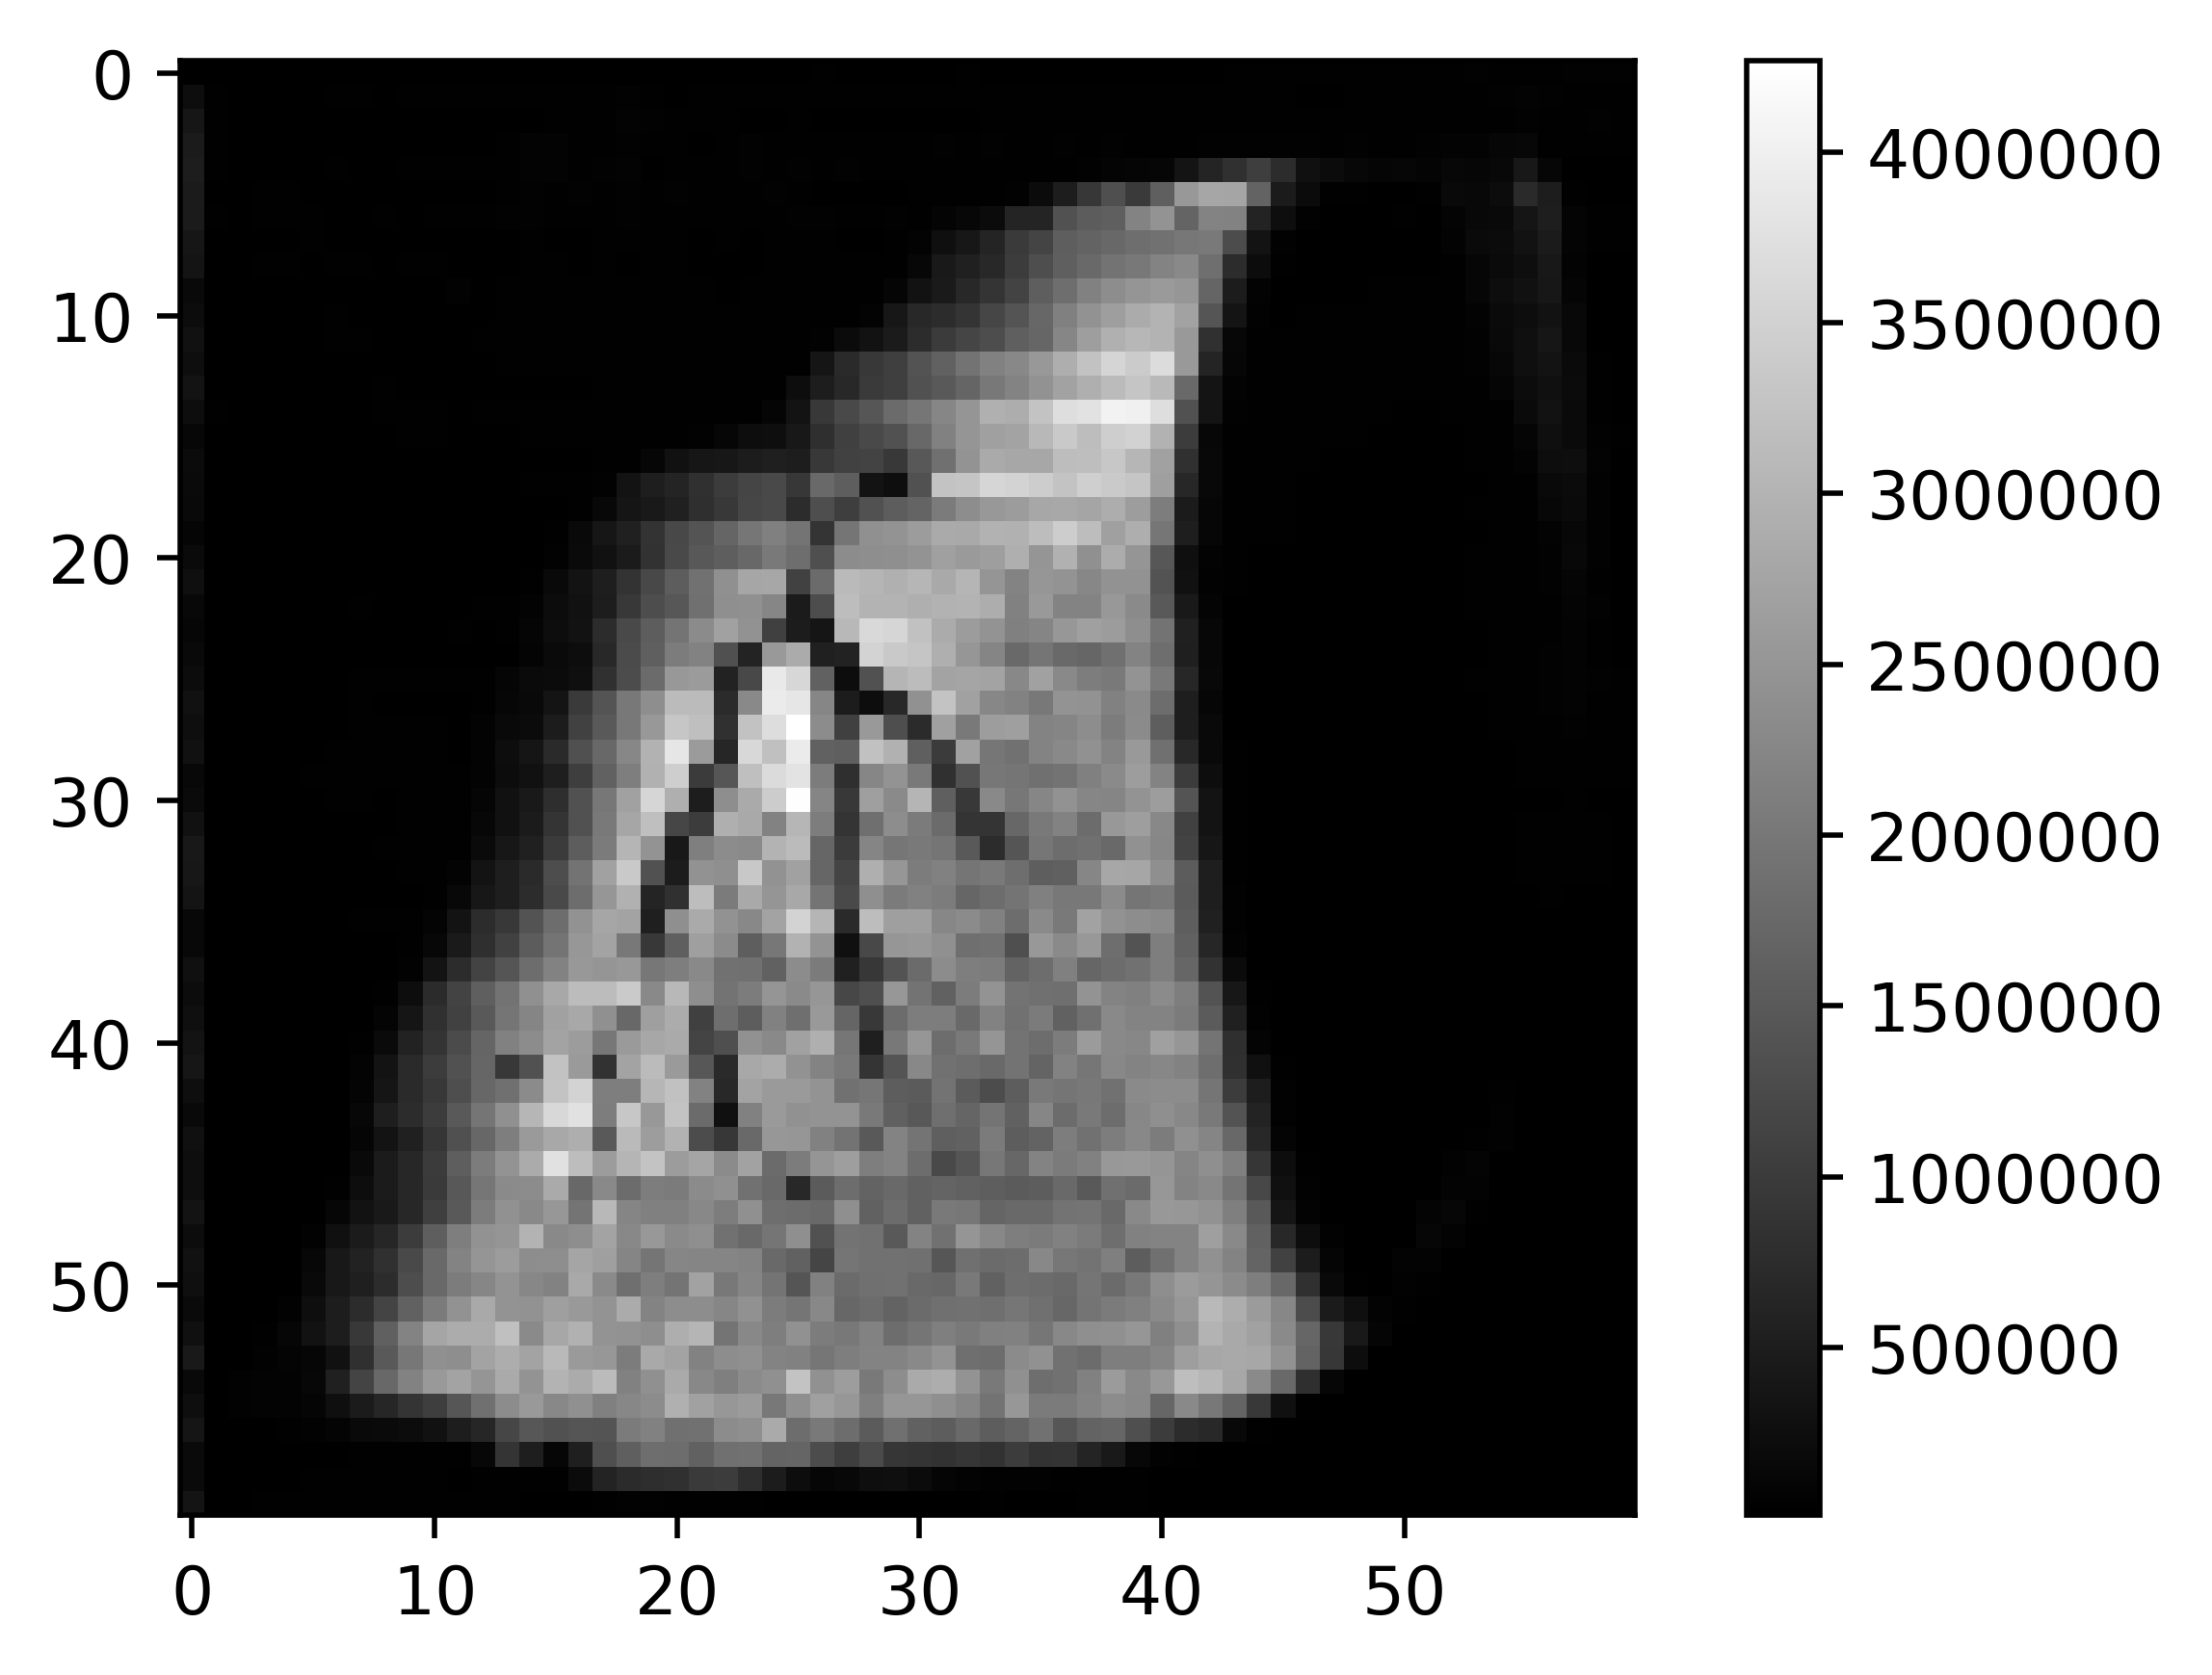

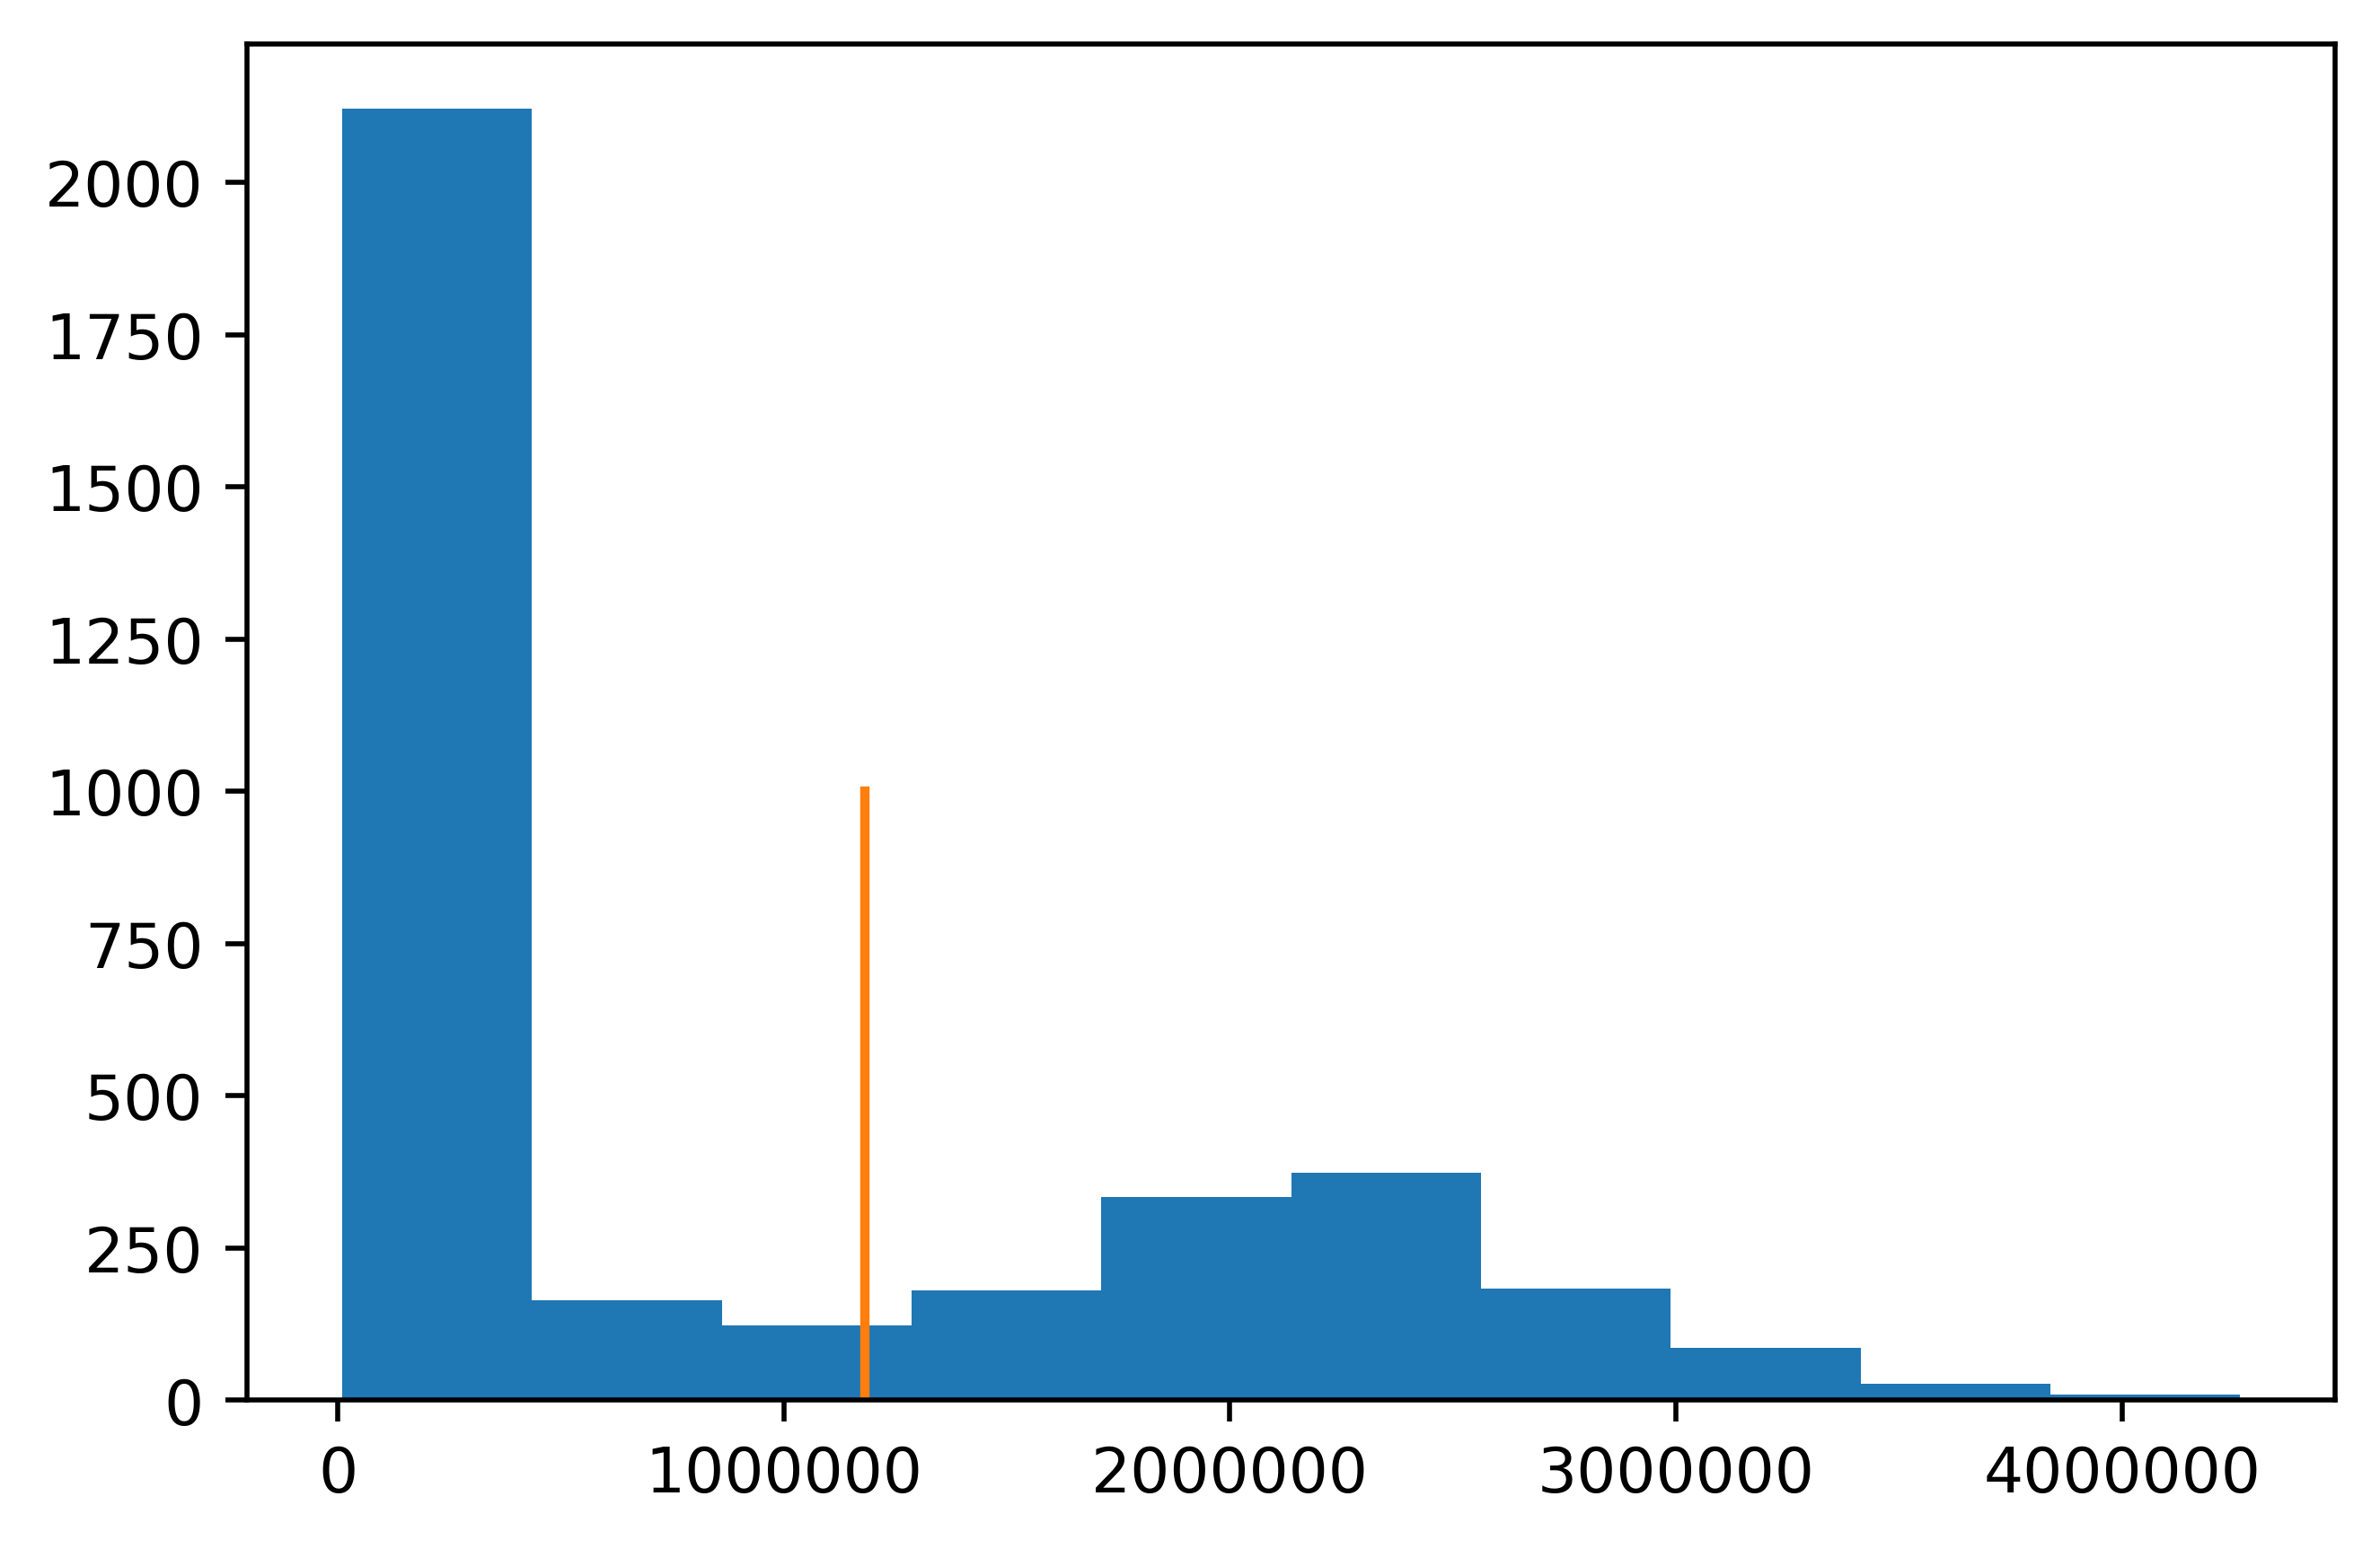

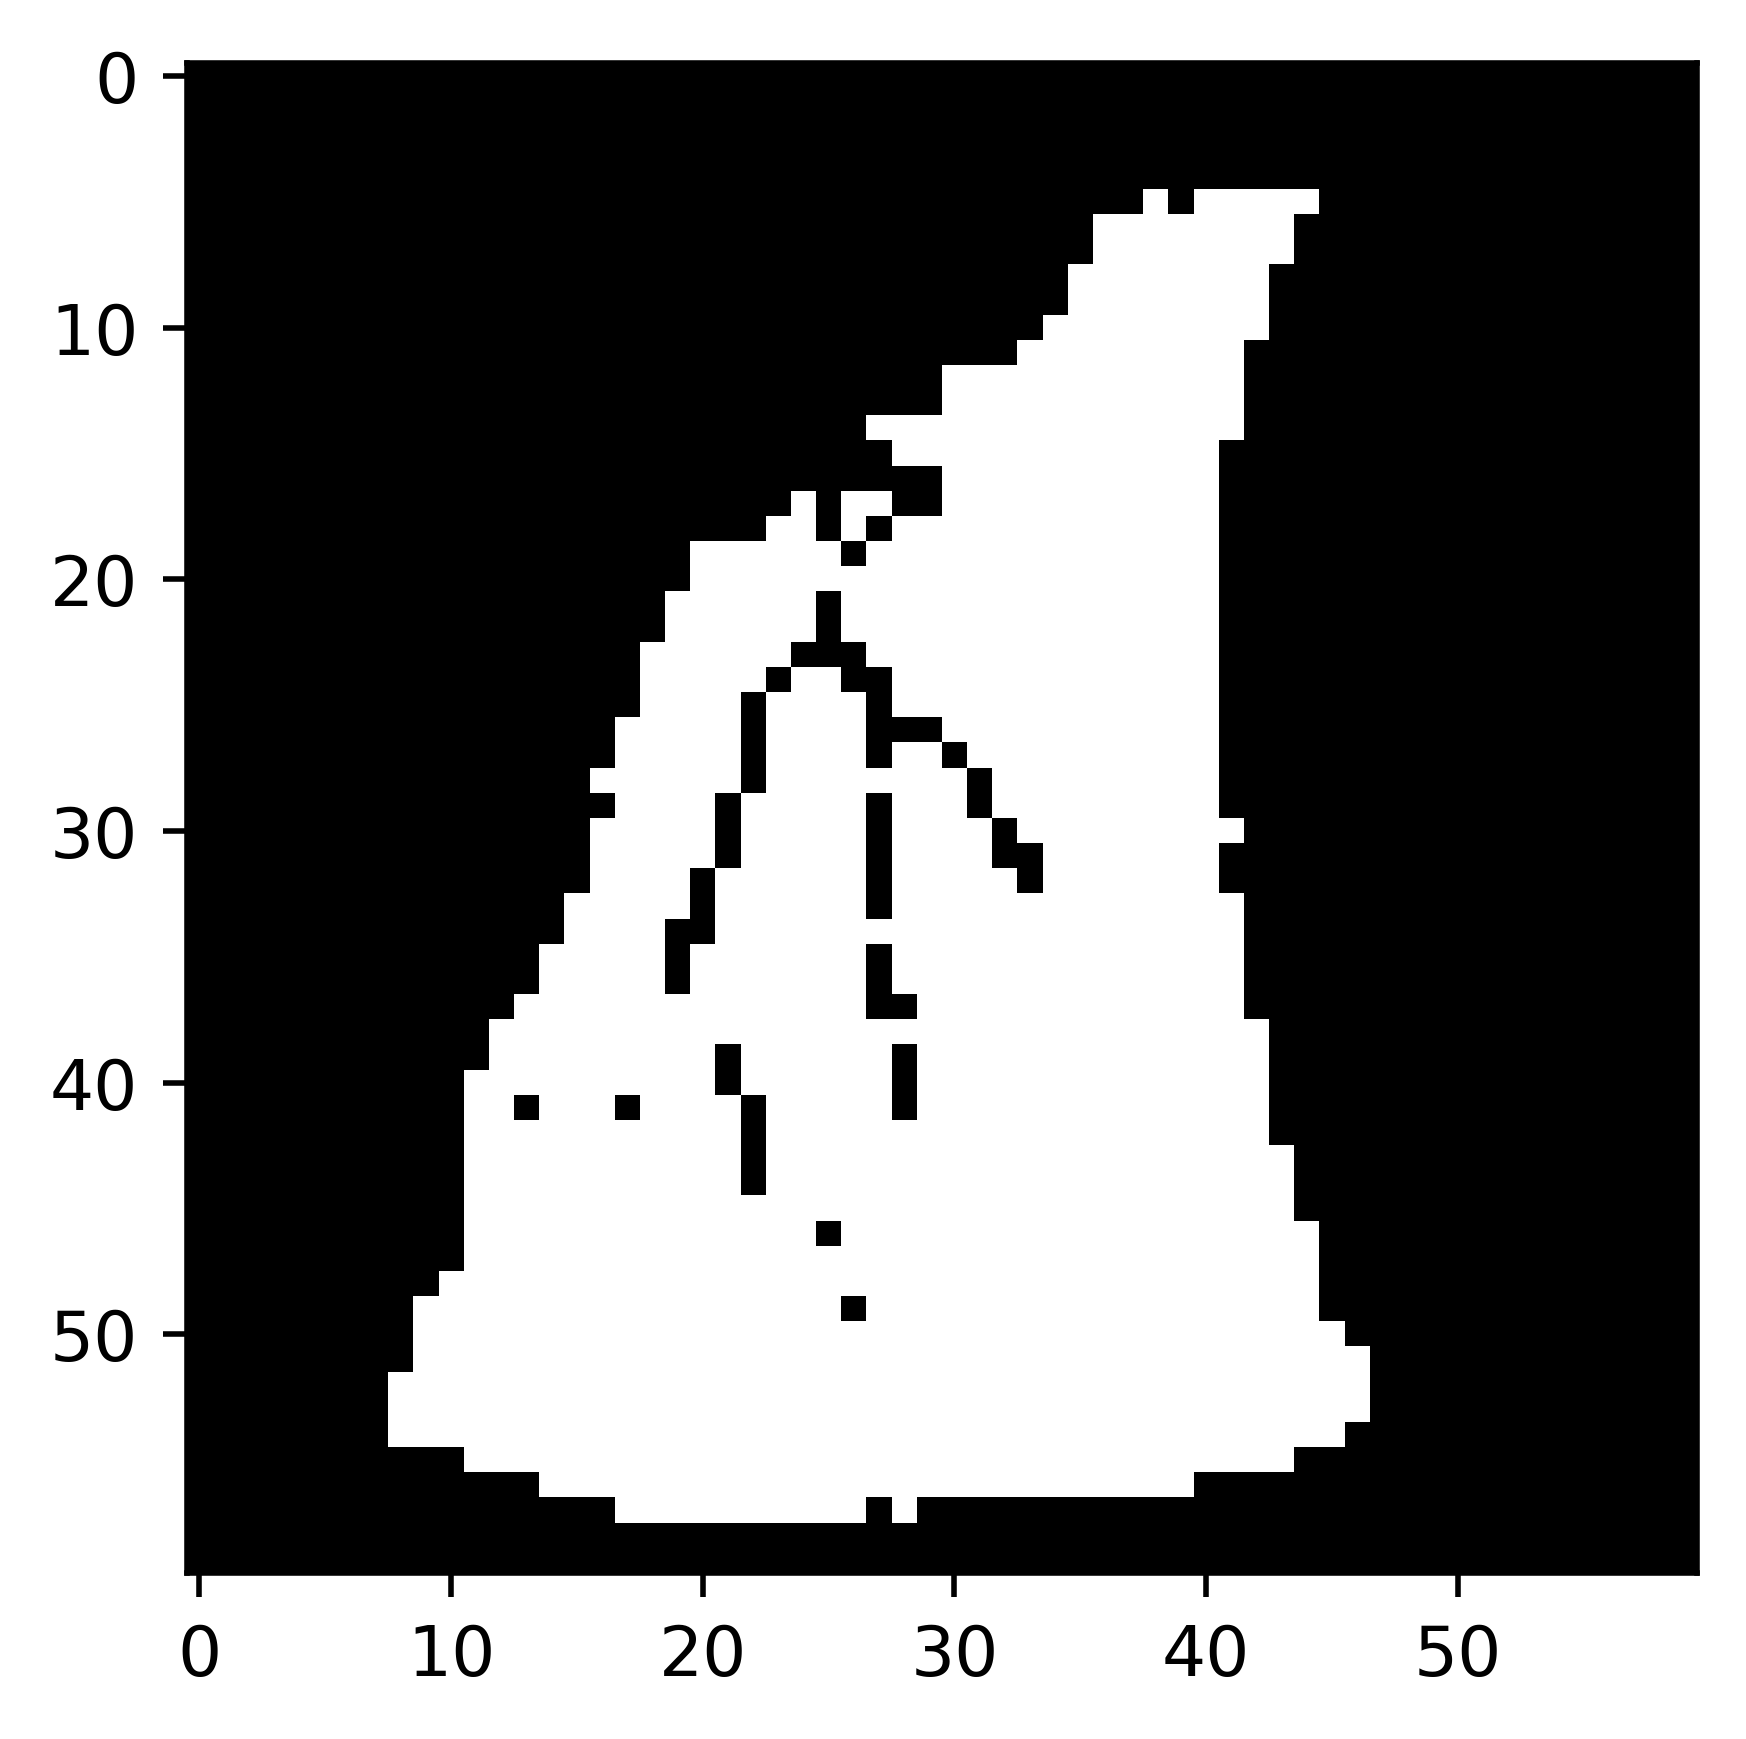

In [5]:
#get thresholded image to define sample boundary

#create TIC image

#go through all features in dataset
sumImage = np.sum([getImage(data,x,nrows,ncols) for x in mzs],axis=0)
   
#show image and pixel histogram    
plt.imshow(sumImage,cmap=colormap)
plt.colorbar()
plt.figure()
plt.hist(sumImage.flatten())

#get threshold and mask image
threshold = skimage.filters.threshold_otsu(sumImage)

imageBoundary = sumImage > threshold

plt.plot([threshold,threshold],[0,1000])

plt.figure()

#show masked image
plt.imshow(imageBoundary,cmap=colormap)

#apply moving average filter
offset = int((convSquare-1)/2)
tensorFilt = np.zeros((len(tensor),nrows-2*offset,ncols-2*offset)) #new tensor for filtered image
newImageBoundary = np.zeros((nrows-2*offset,ncols-2*offset)) #new image boundary

#iterate through pixels
for r in range(offset,nrows-offset):
    for c in range(offset,ncols-offset):
        #set masking
        newImageBoundary[r-offset:r+offset+1,c-offset:c+offset+1] = imageBoundary[r,c]
        #average pixels
        for t in range(len(tensor)):
            tempMat = tensor[t,r-offset:r+offset+1,c-offset:c+offset+1]
            coef = imageBoundary[r-offset:r+offset+1,c-offset:c+offset+1]
            coef = coef / max([1,np.sum(coef)])
            tensorFilt[t,r-offset,c-offset] = np.sum(np.multiply(tempMat,coef))
#normalize so the sum of the signal = 1
normalizeTensor(tensorFilt)

T (mean) =  [0.05834426 0.15640117 0.78525456]


Text(0.5, 1.0, 'D')

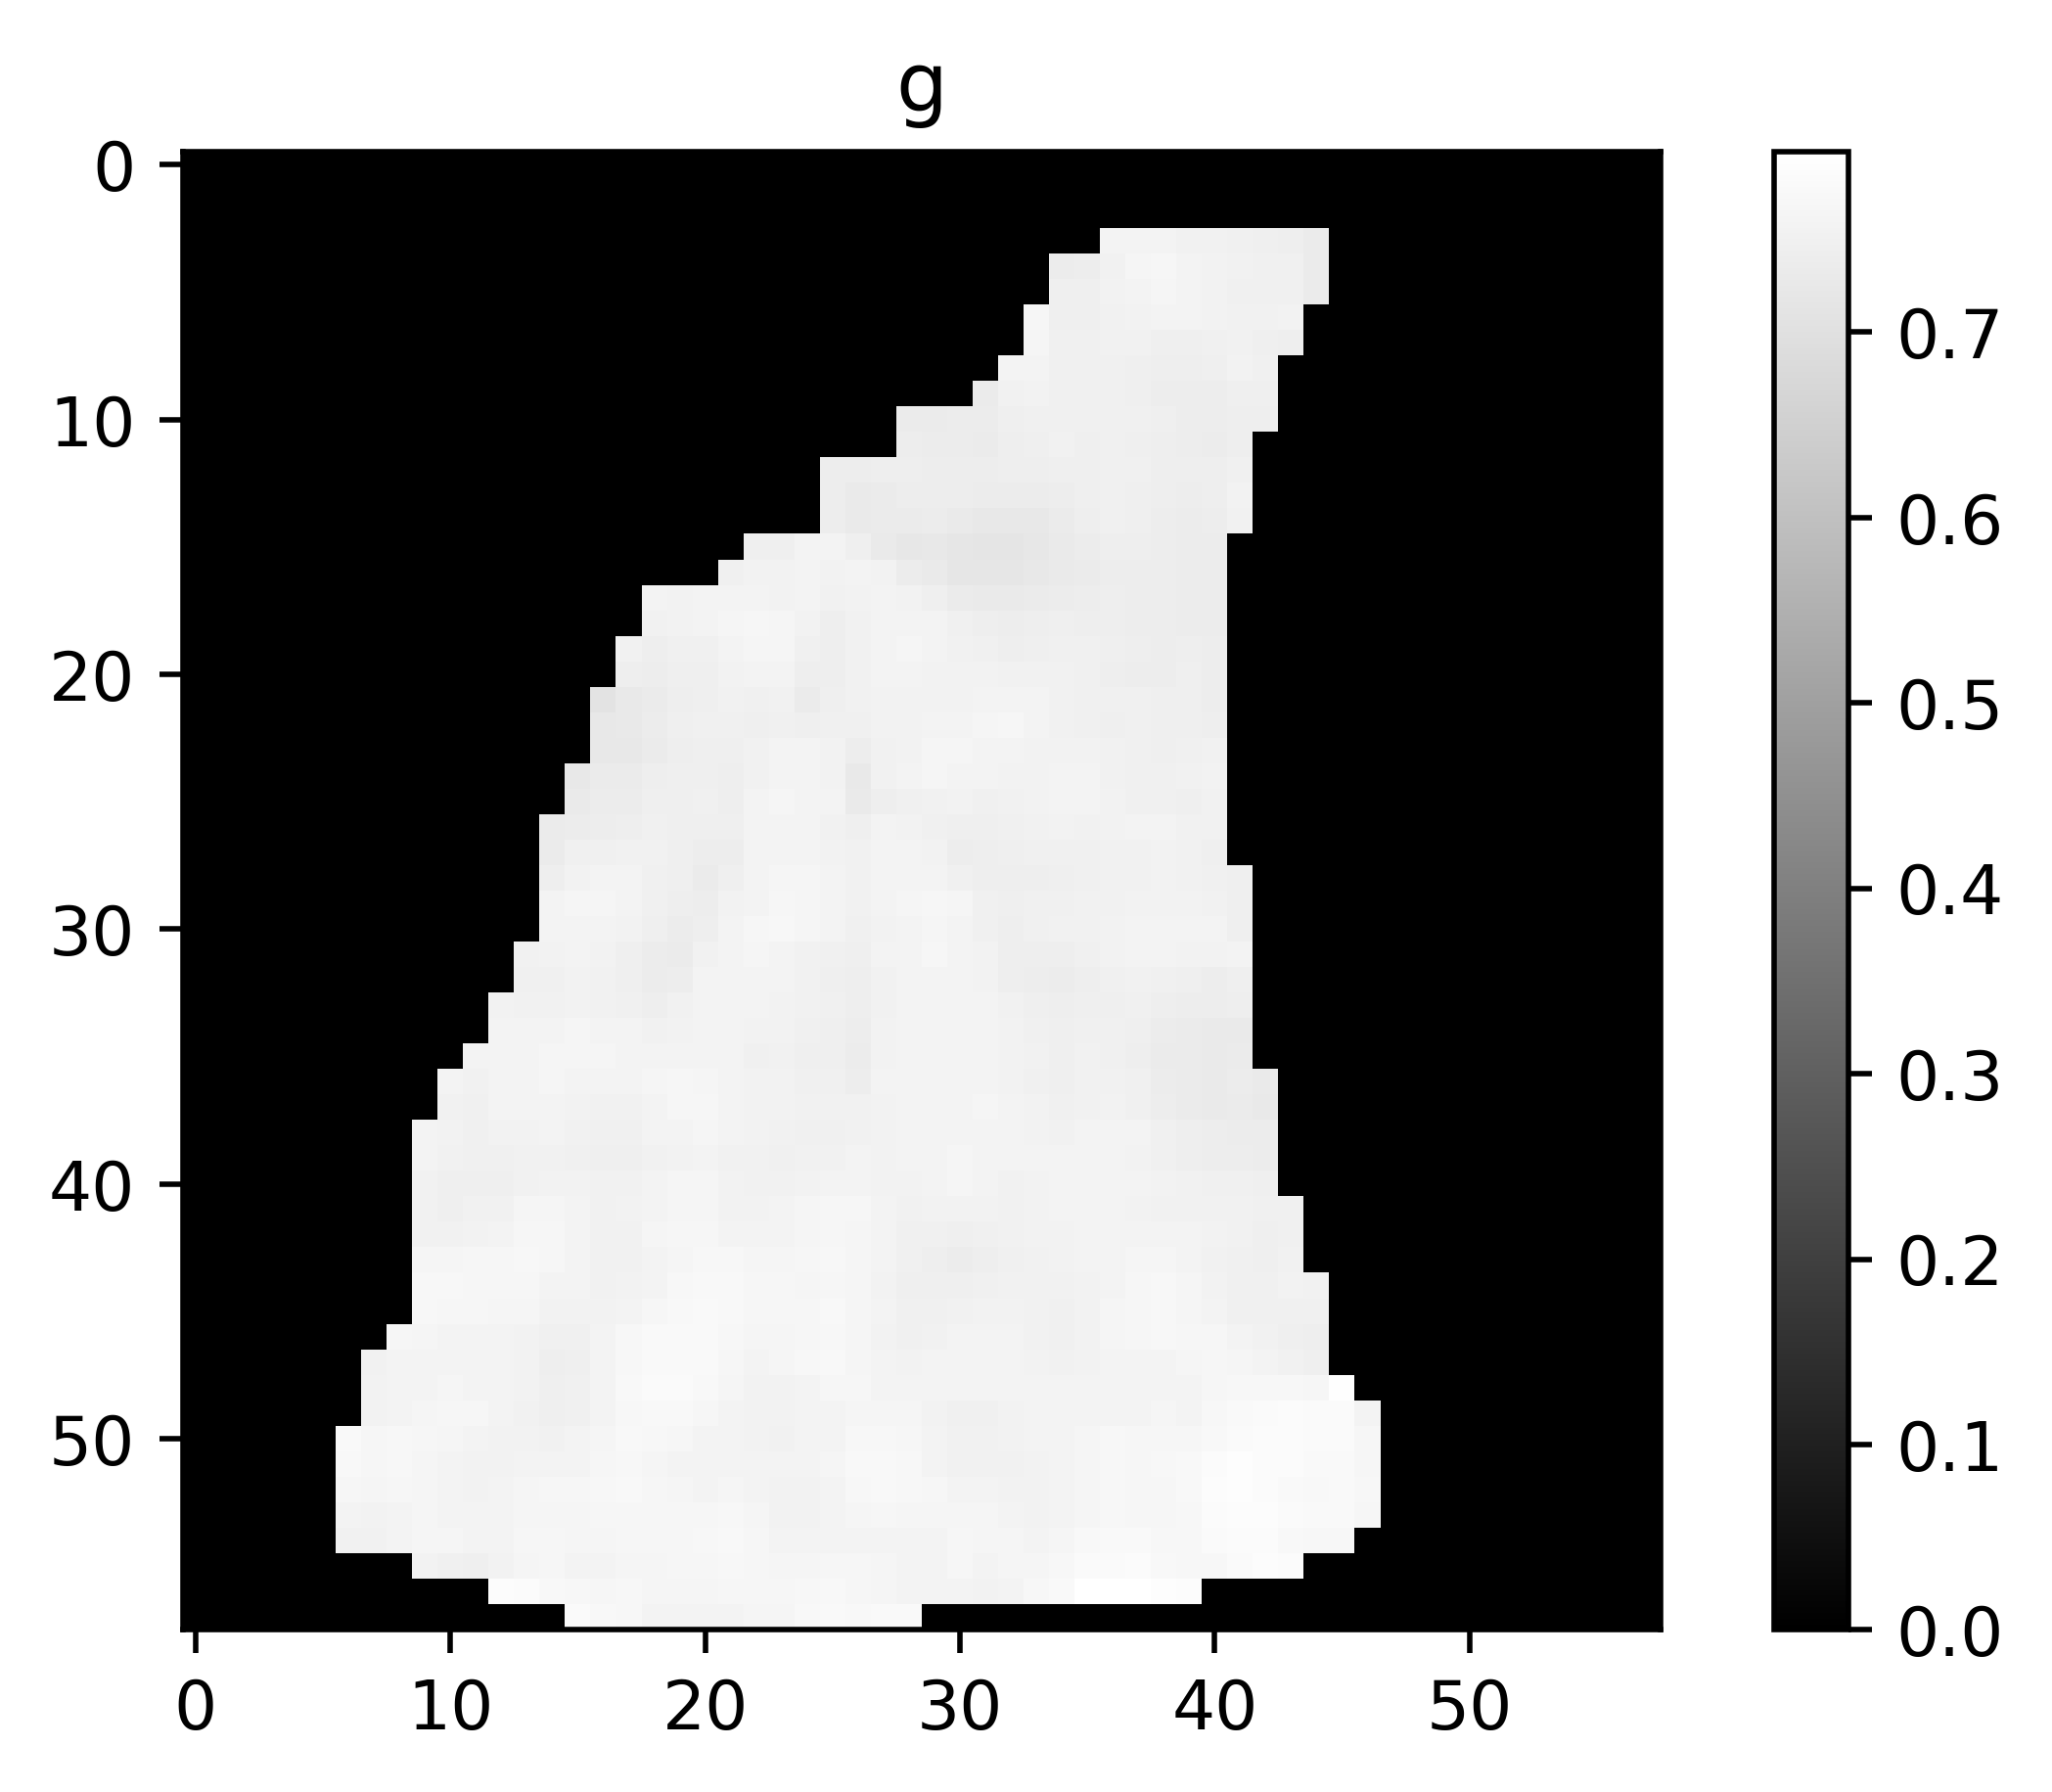

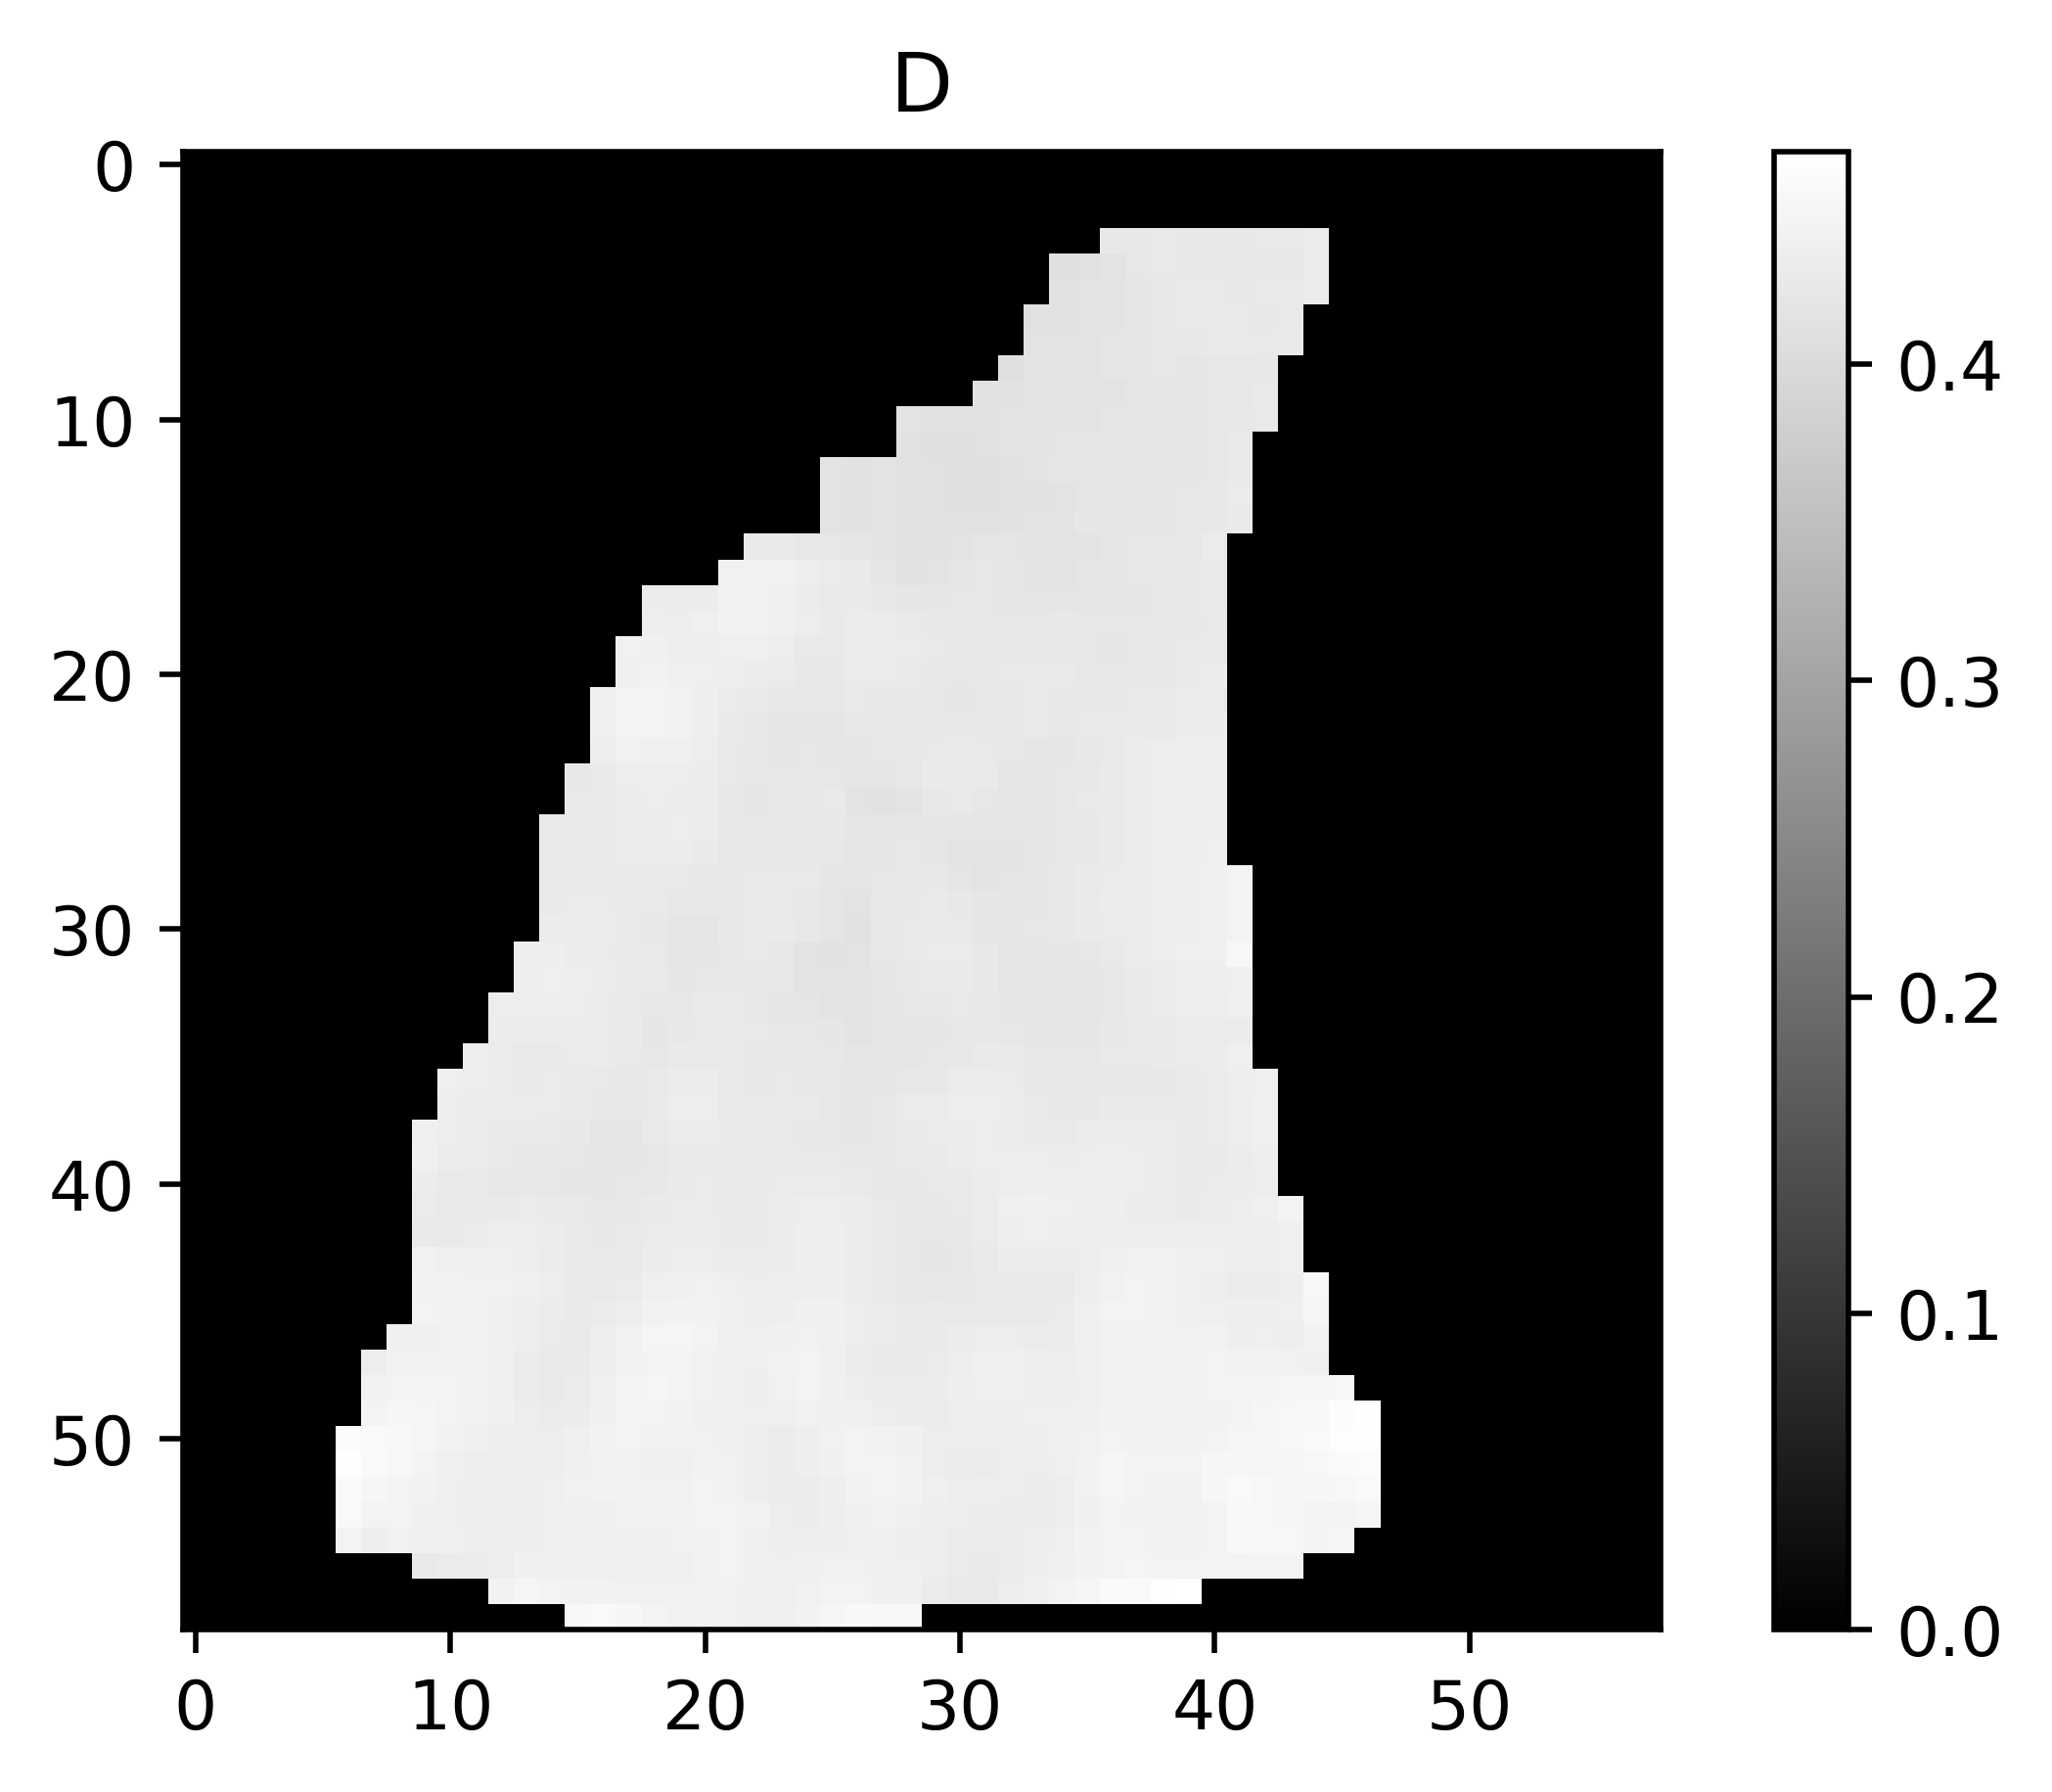

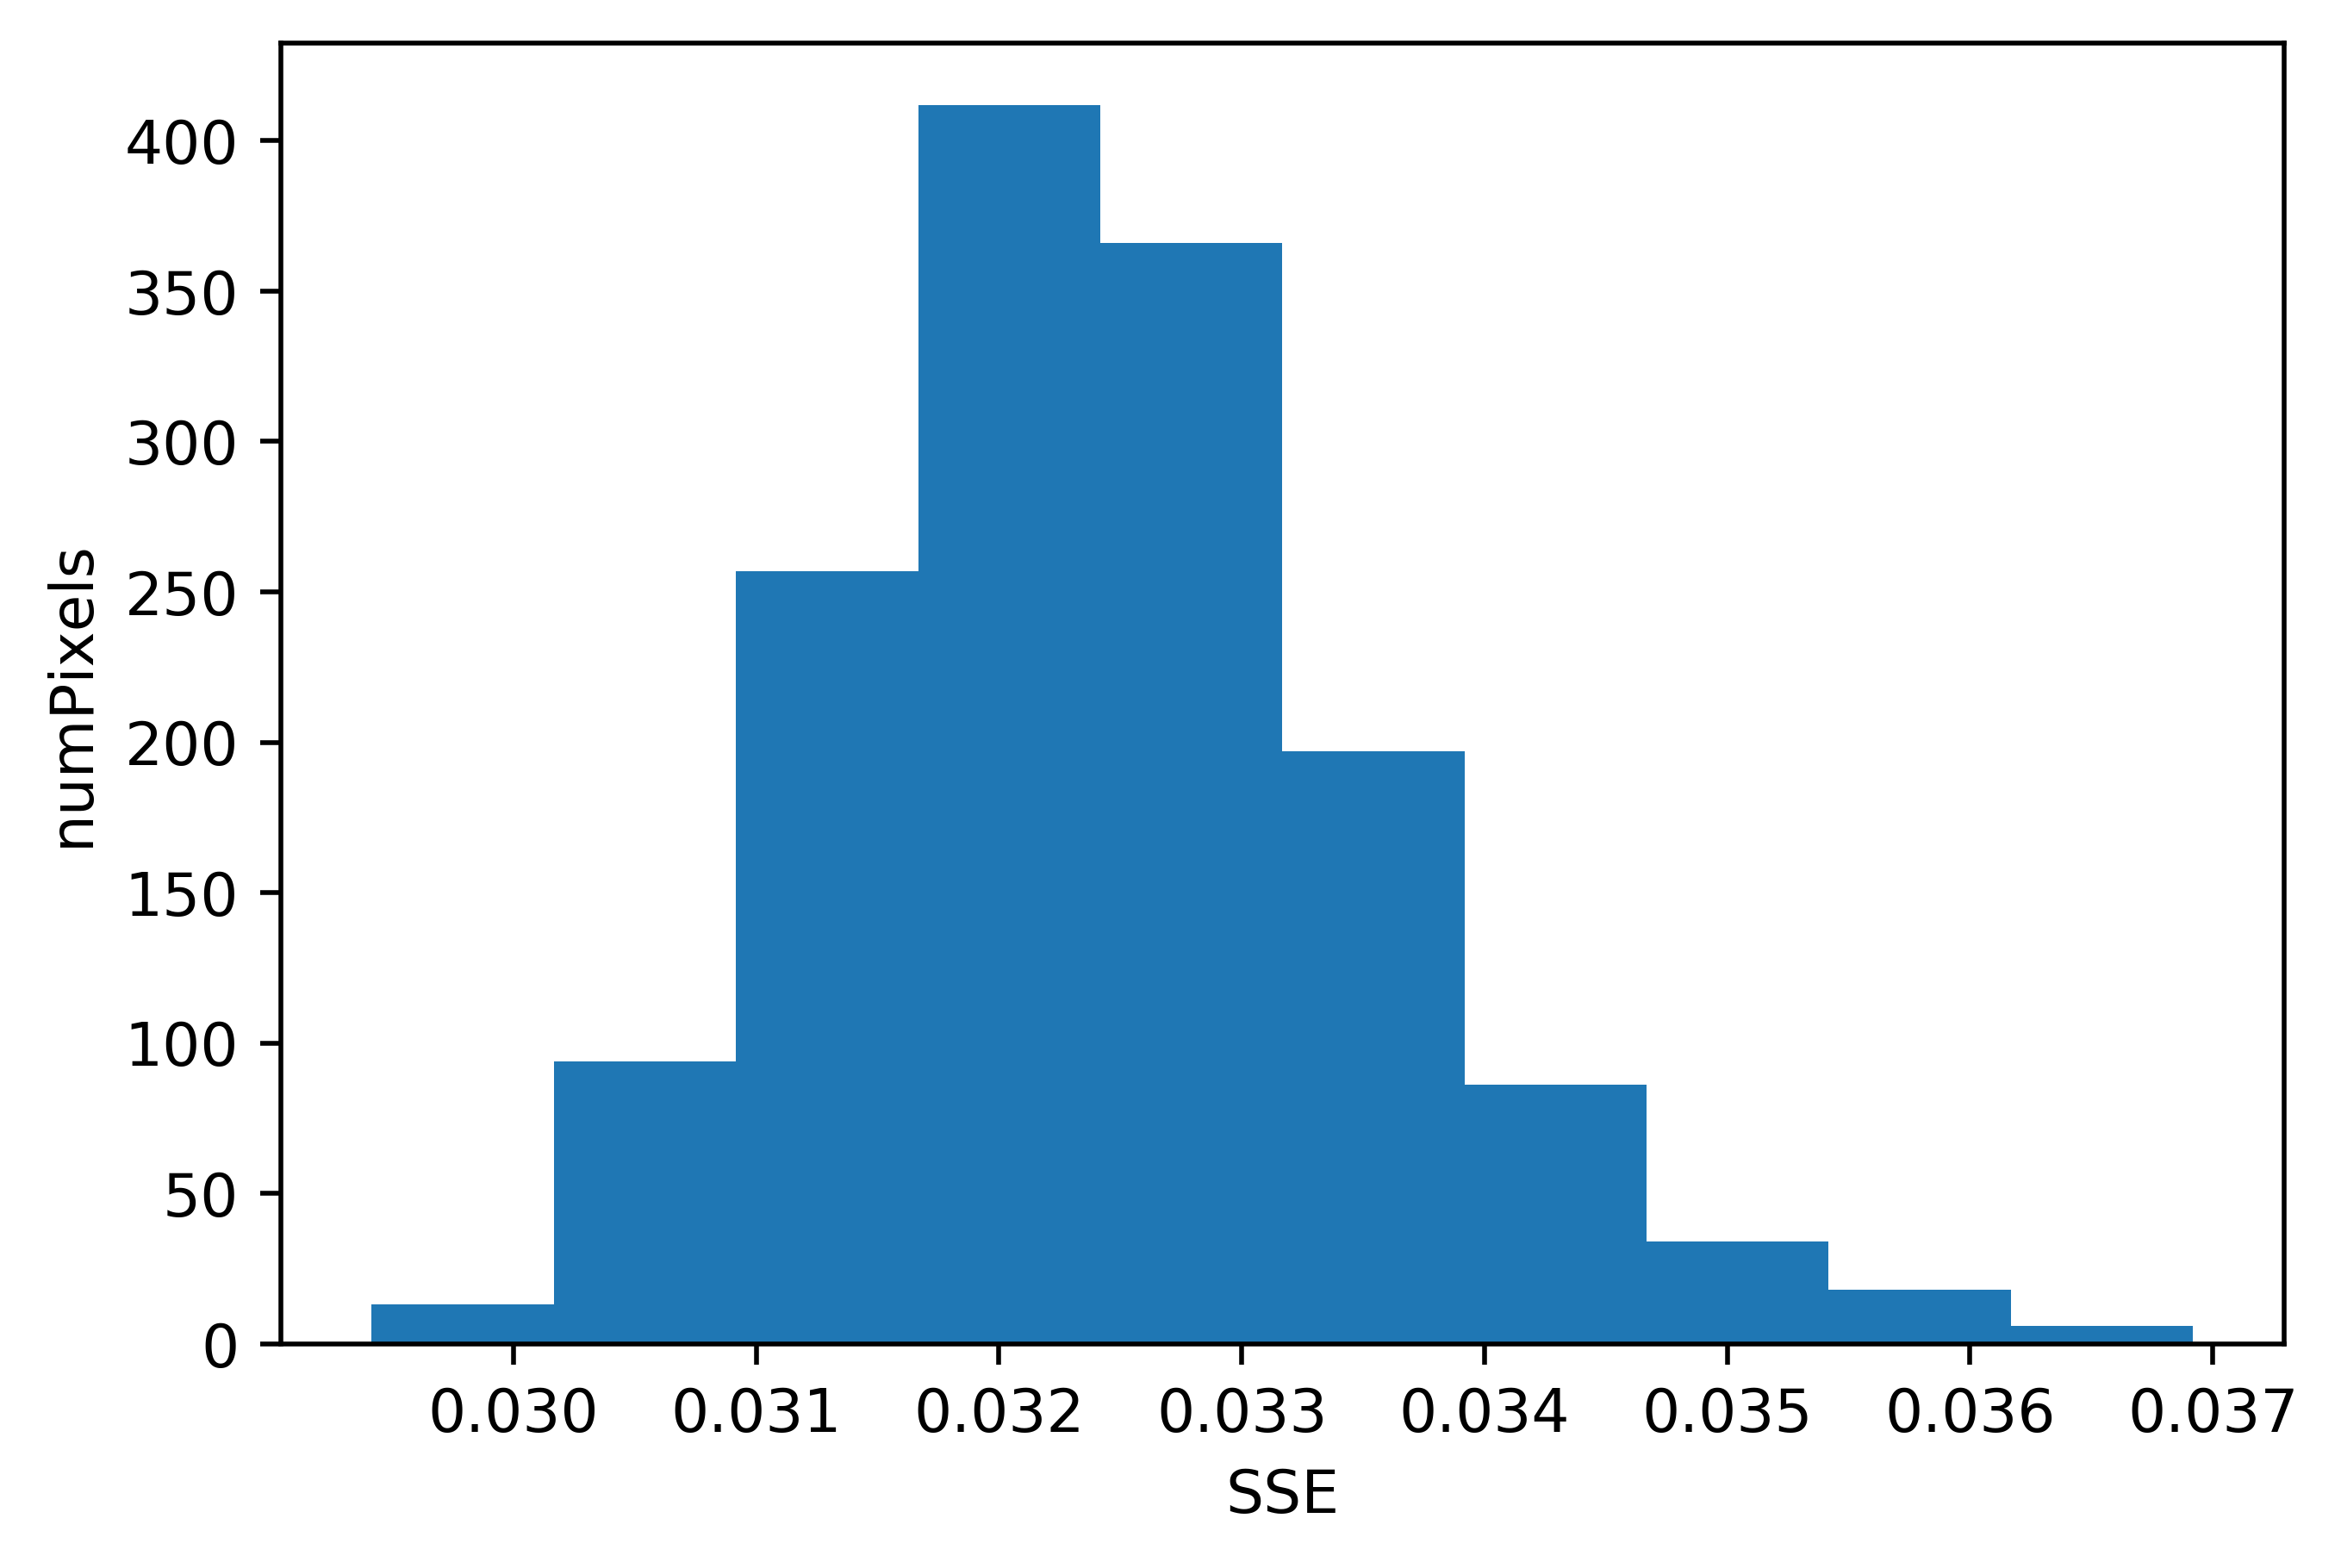

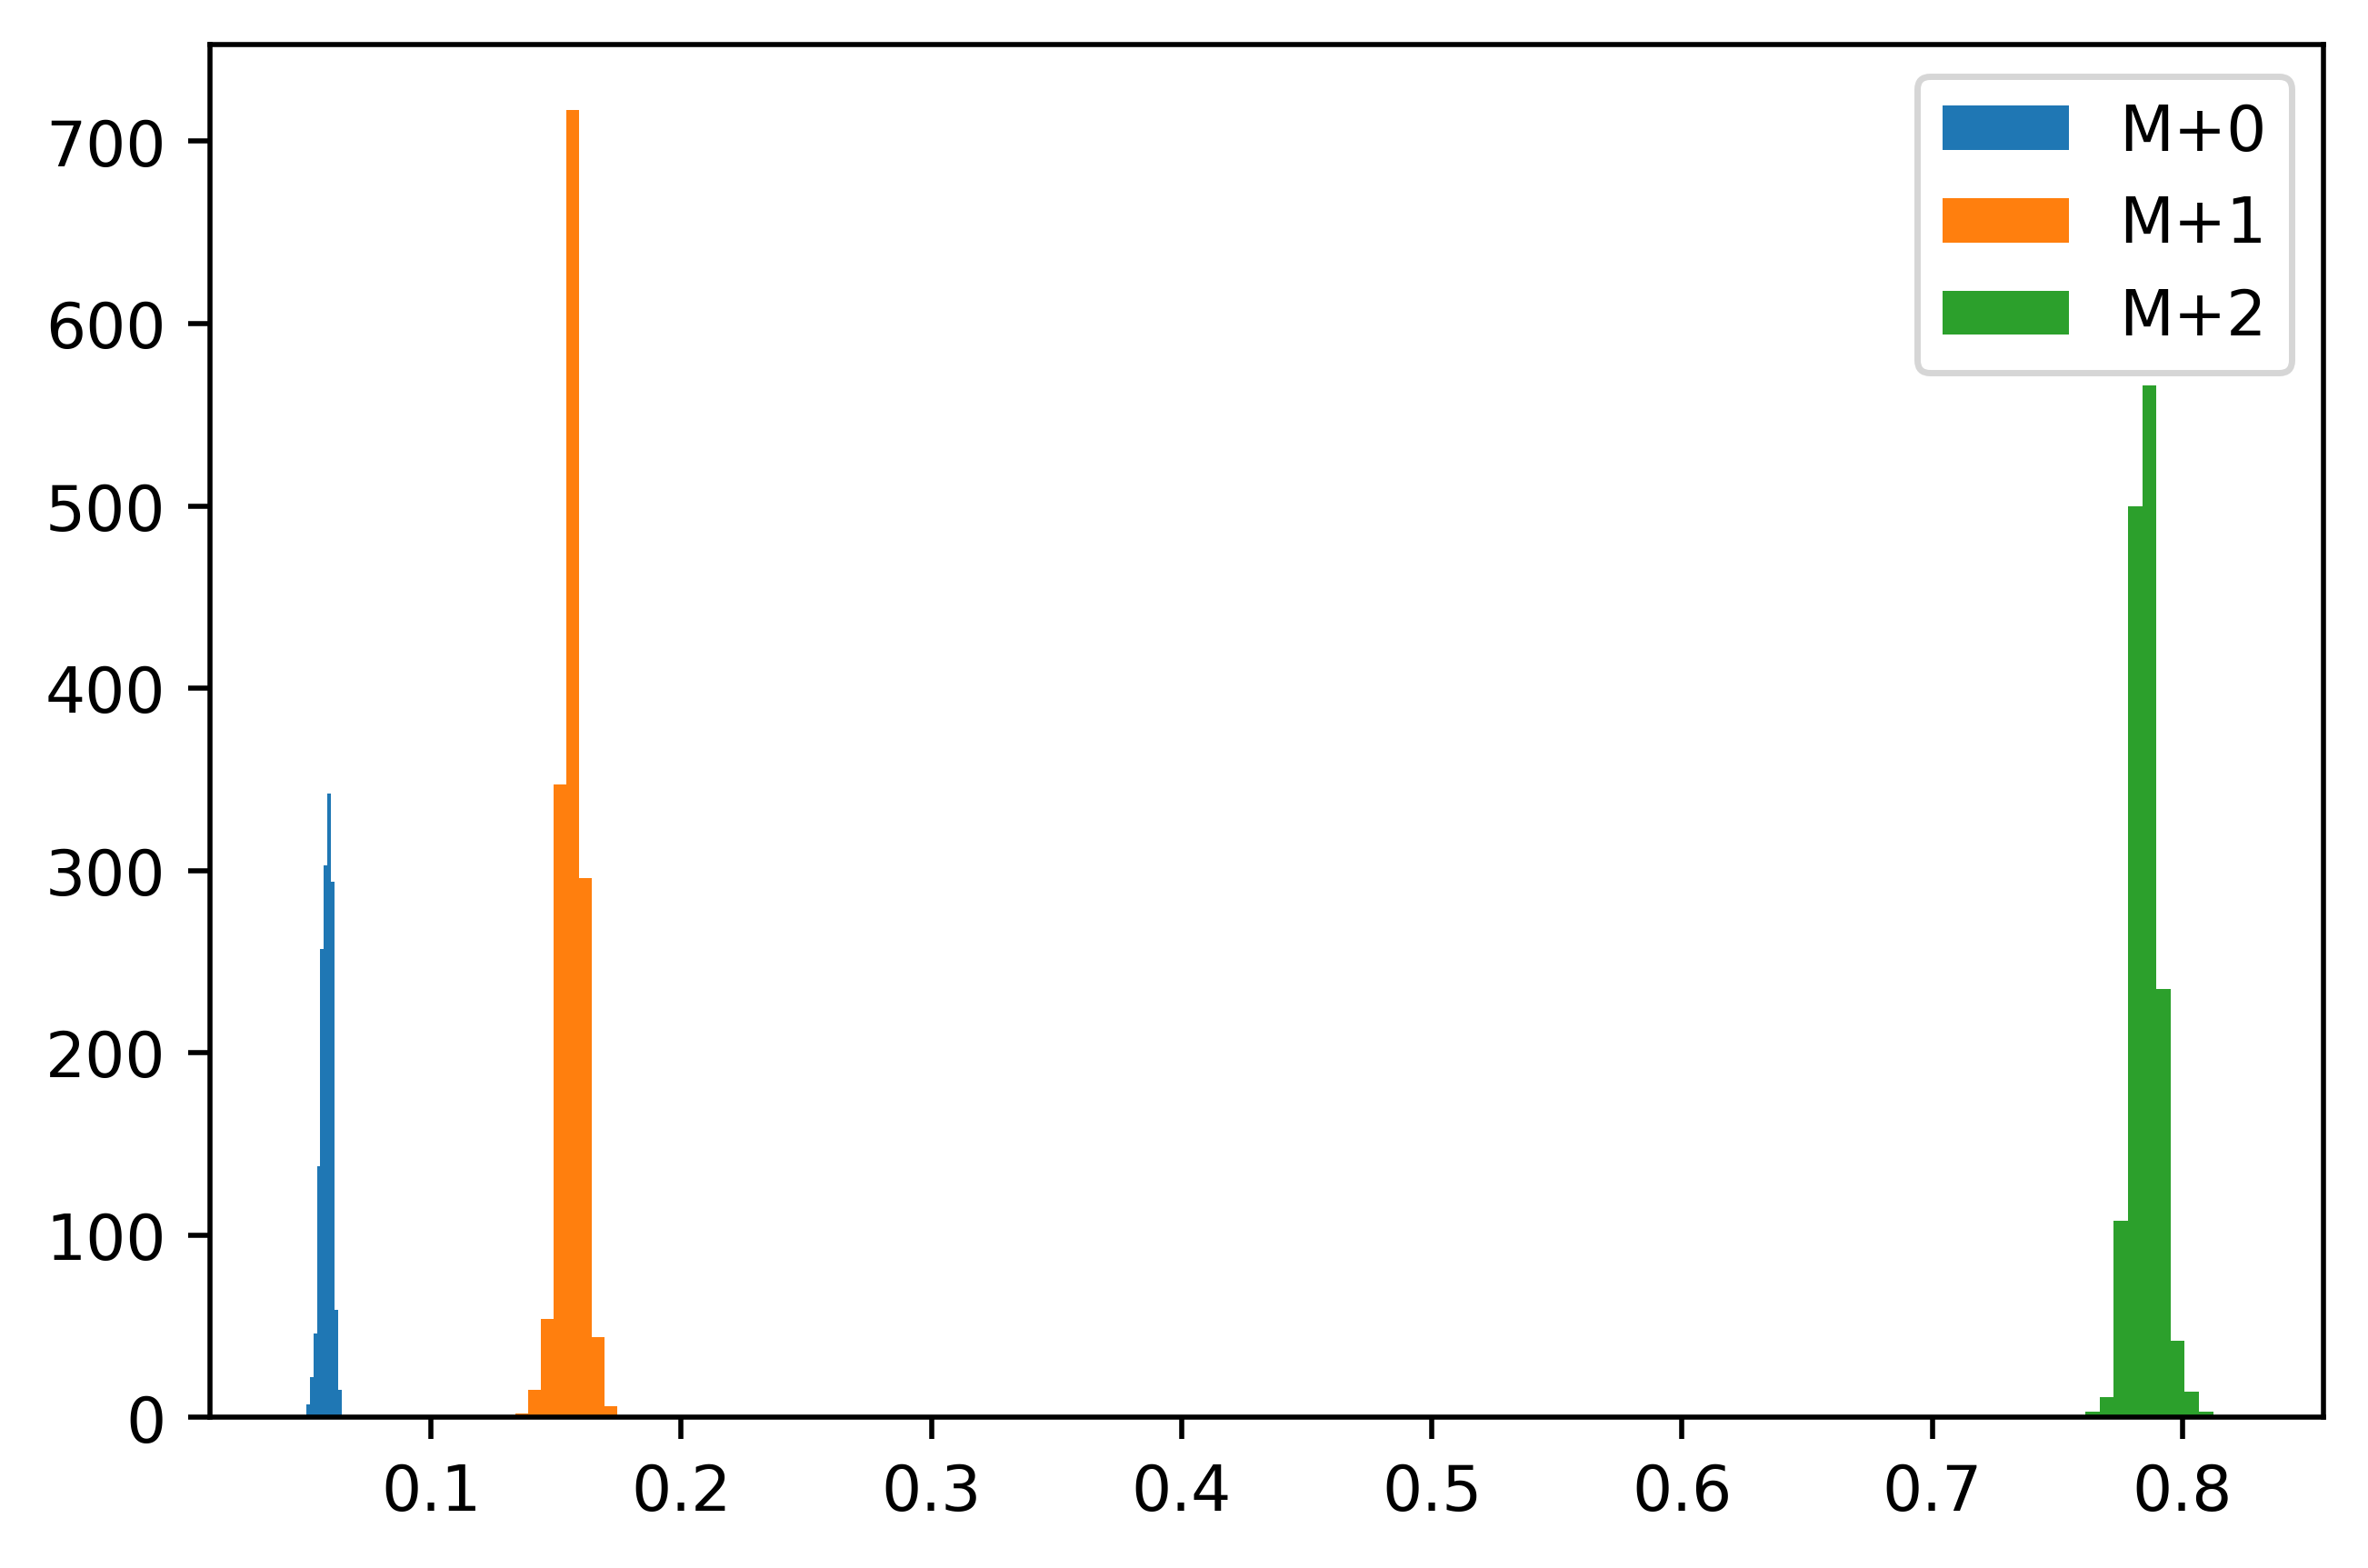

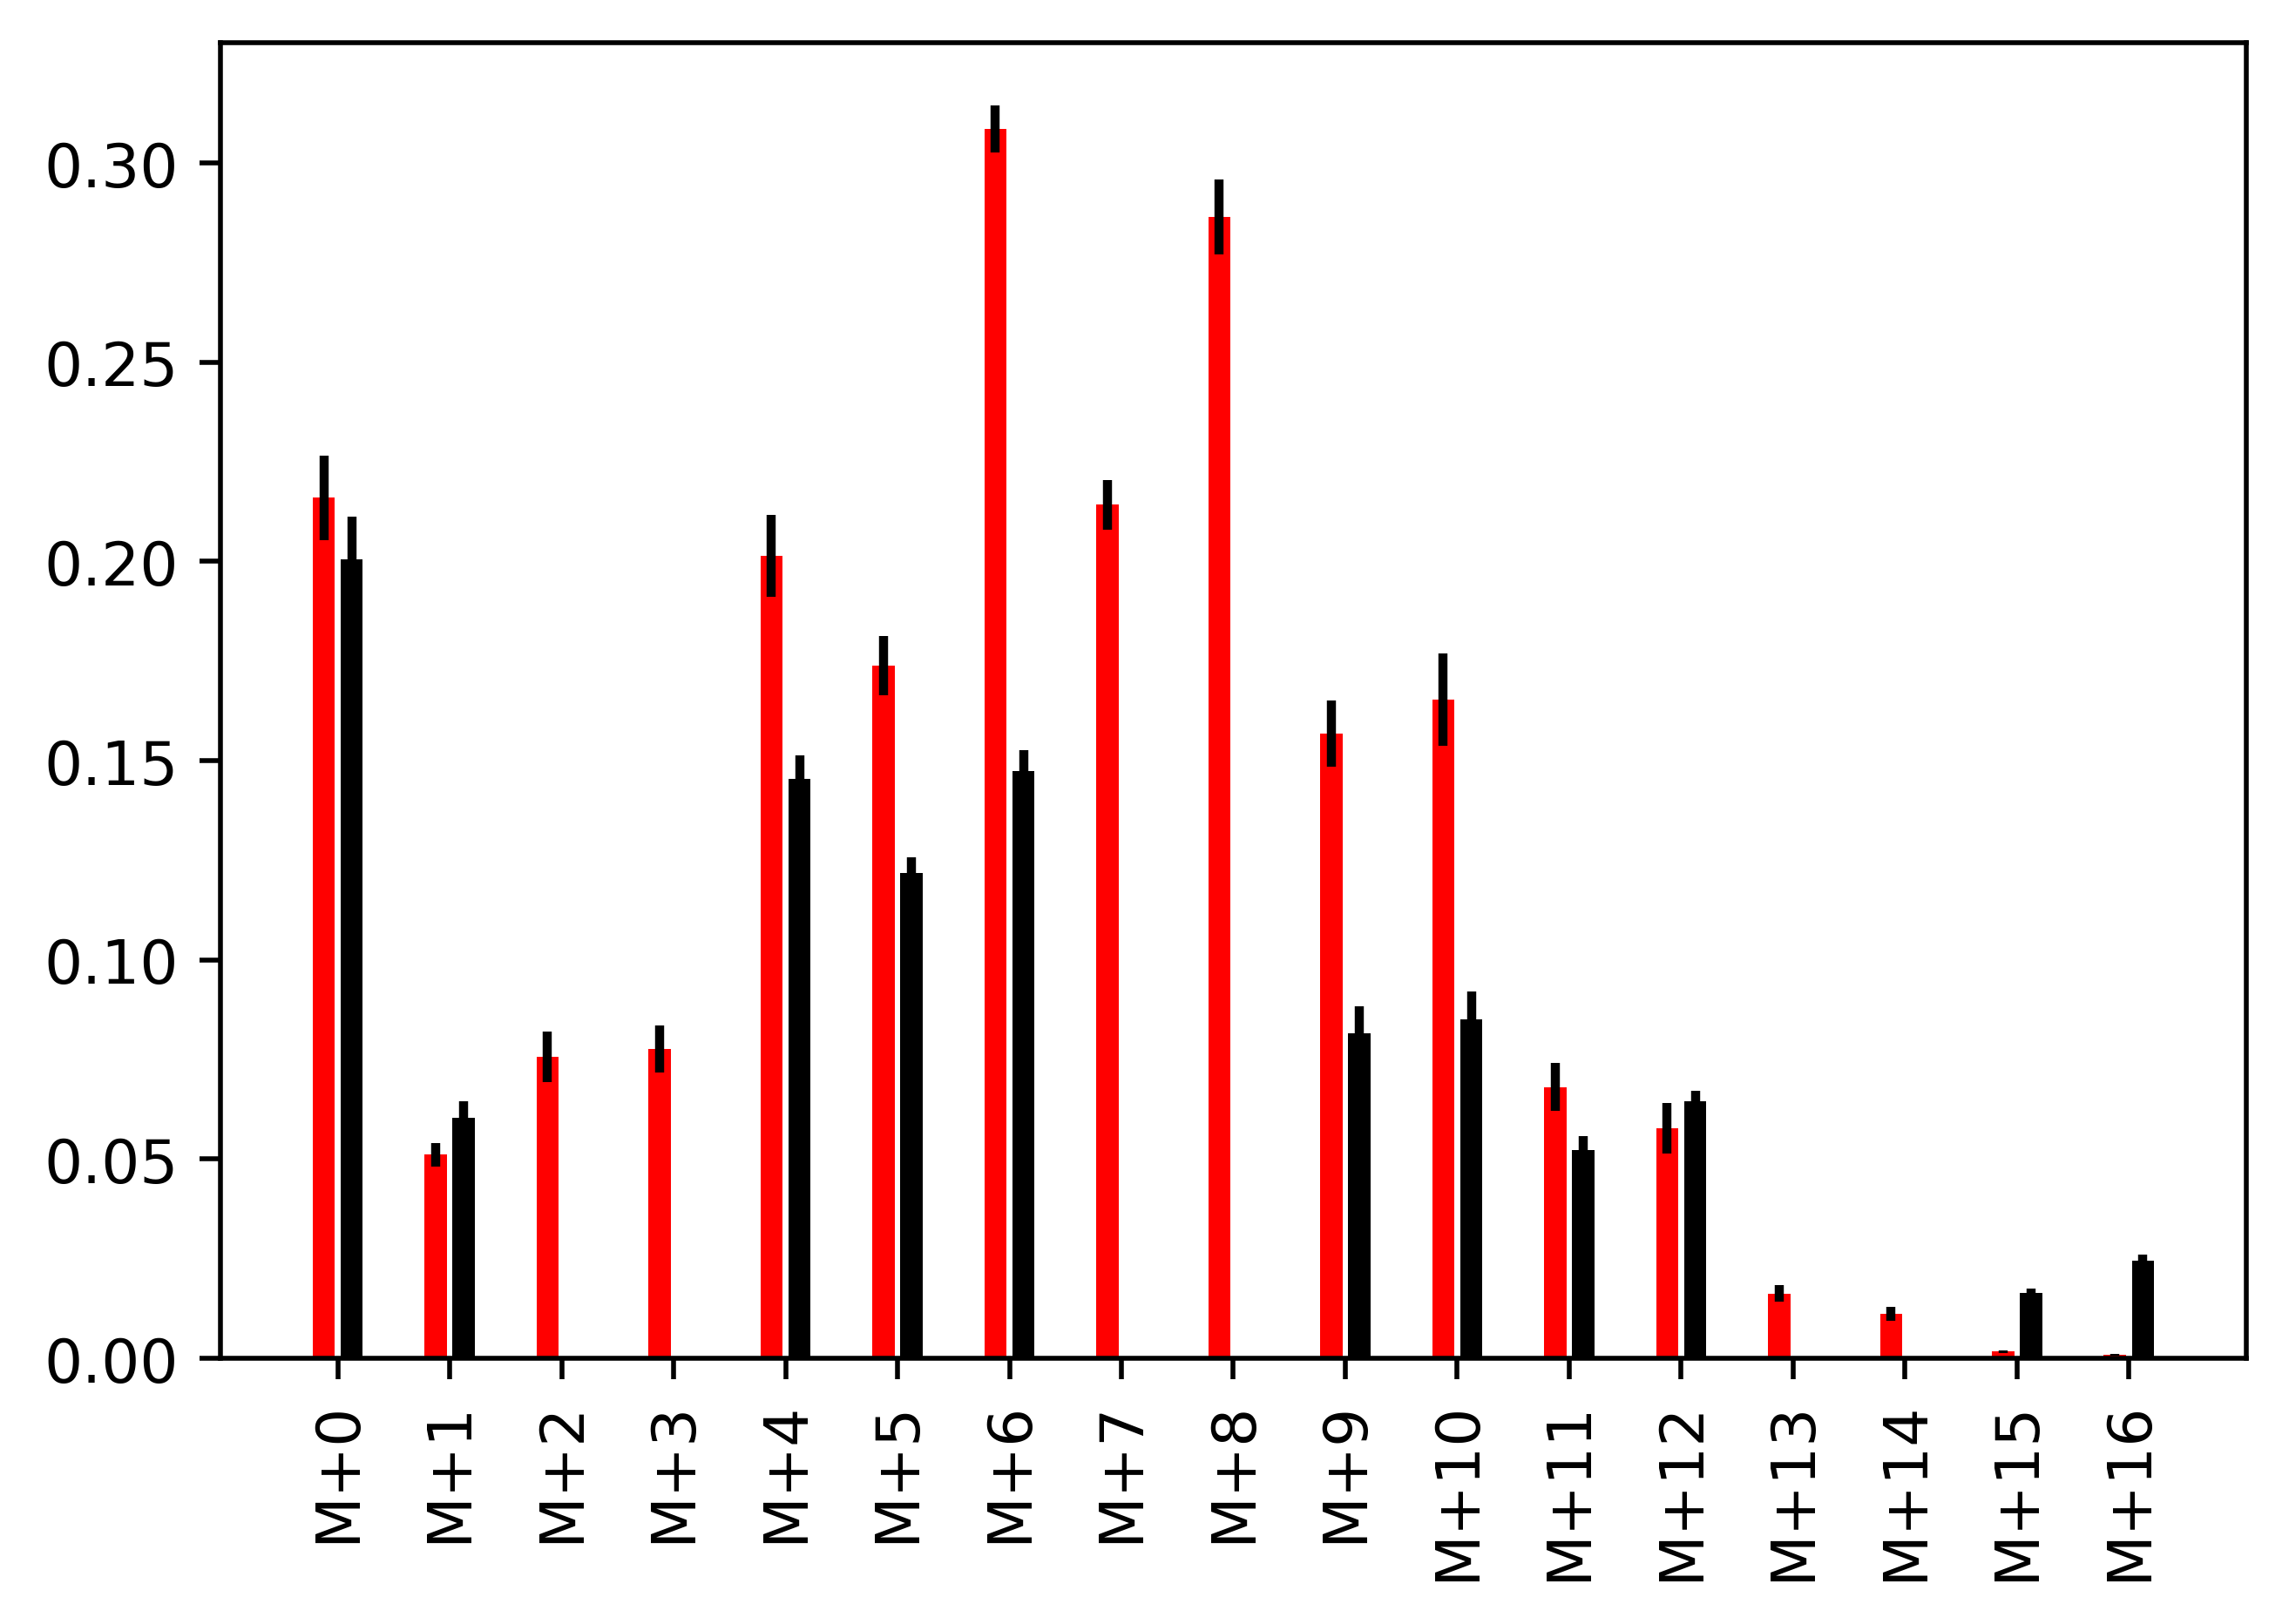

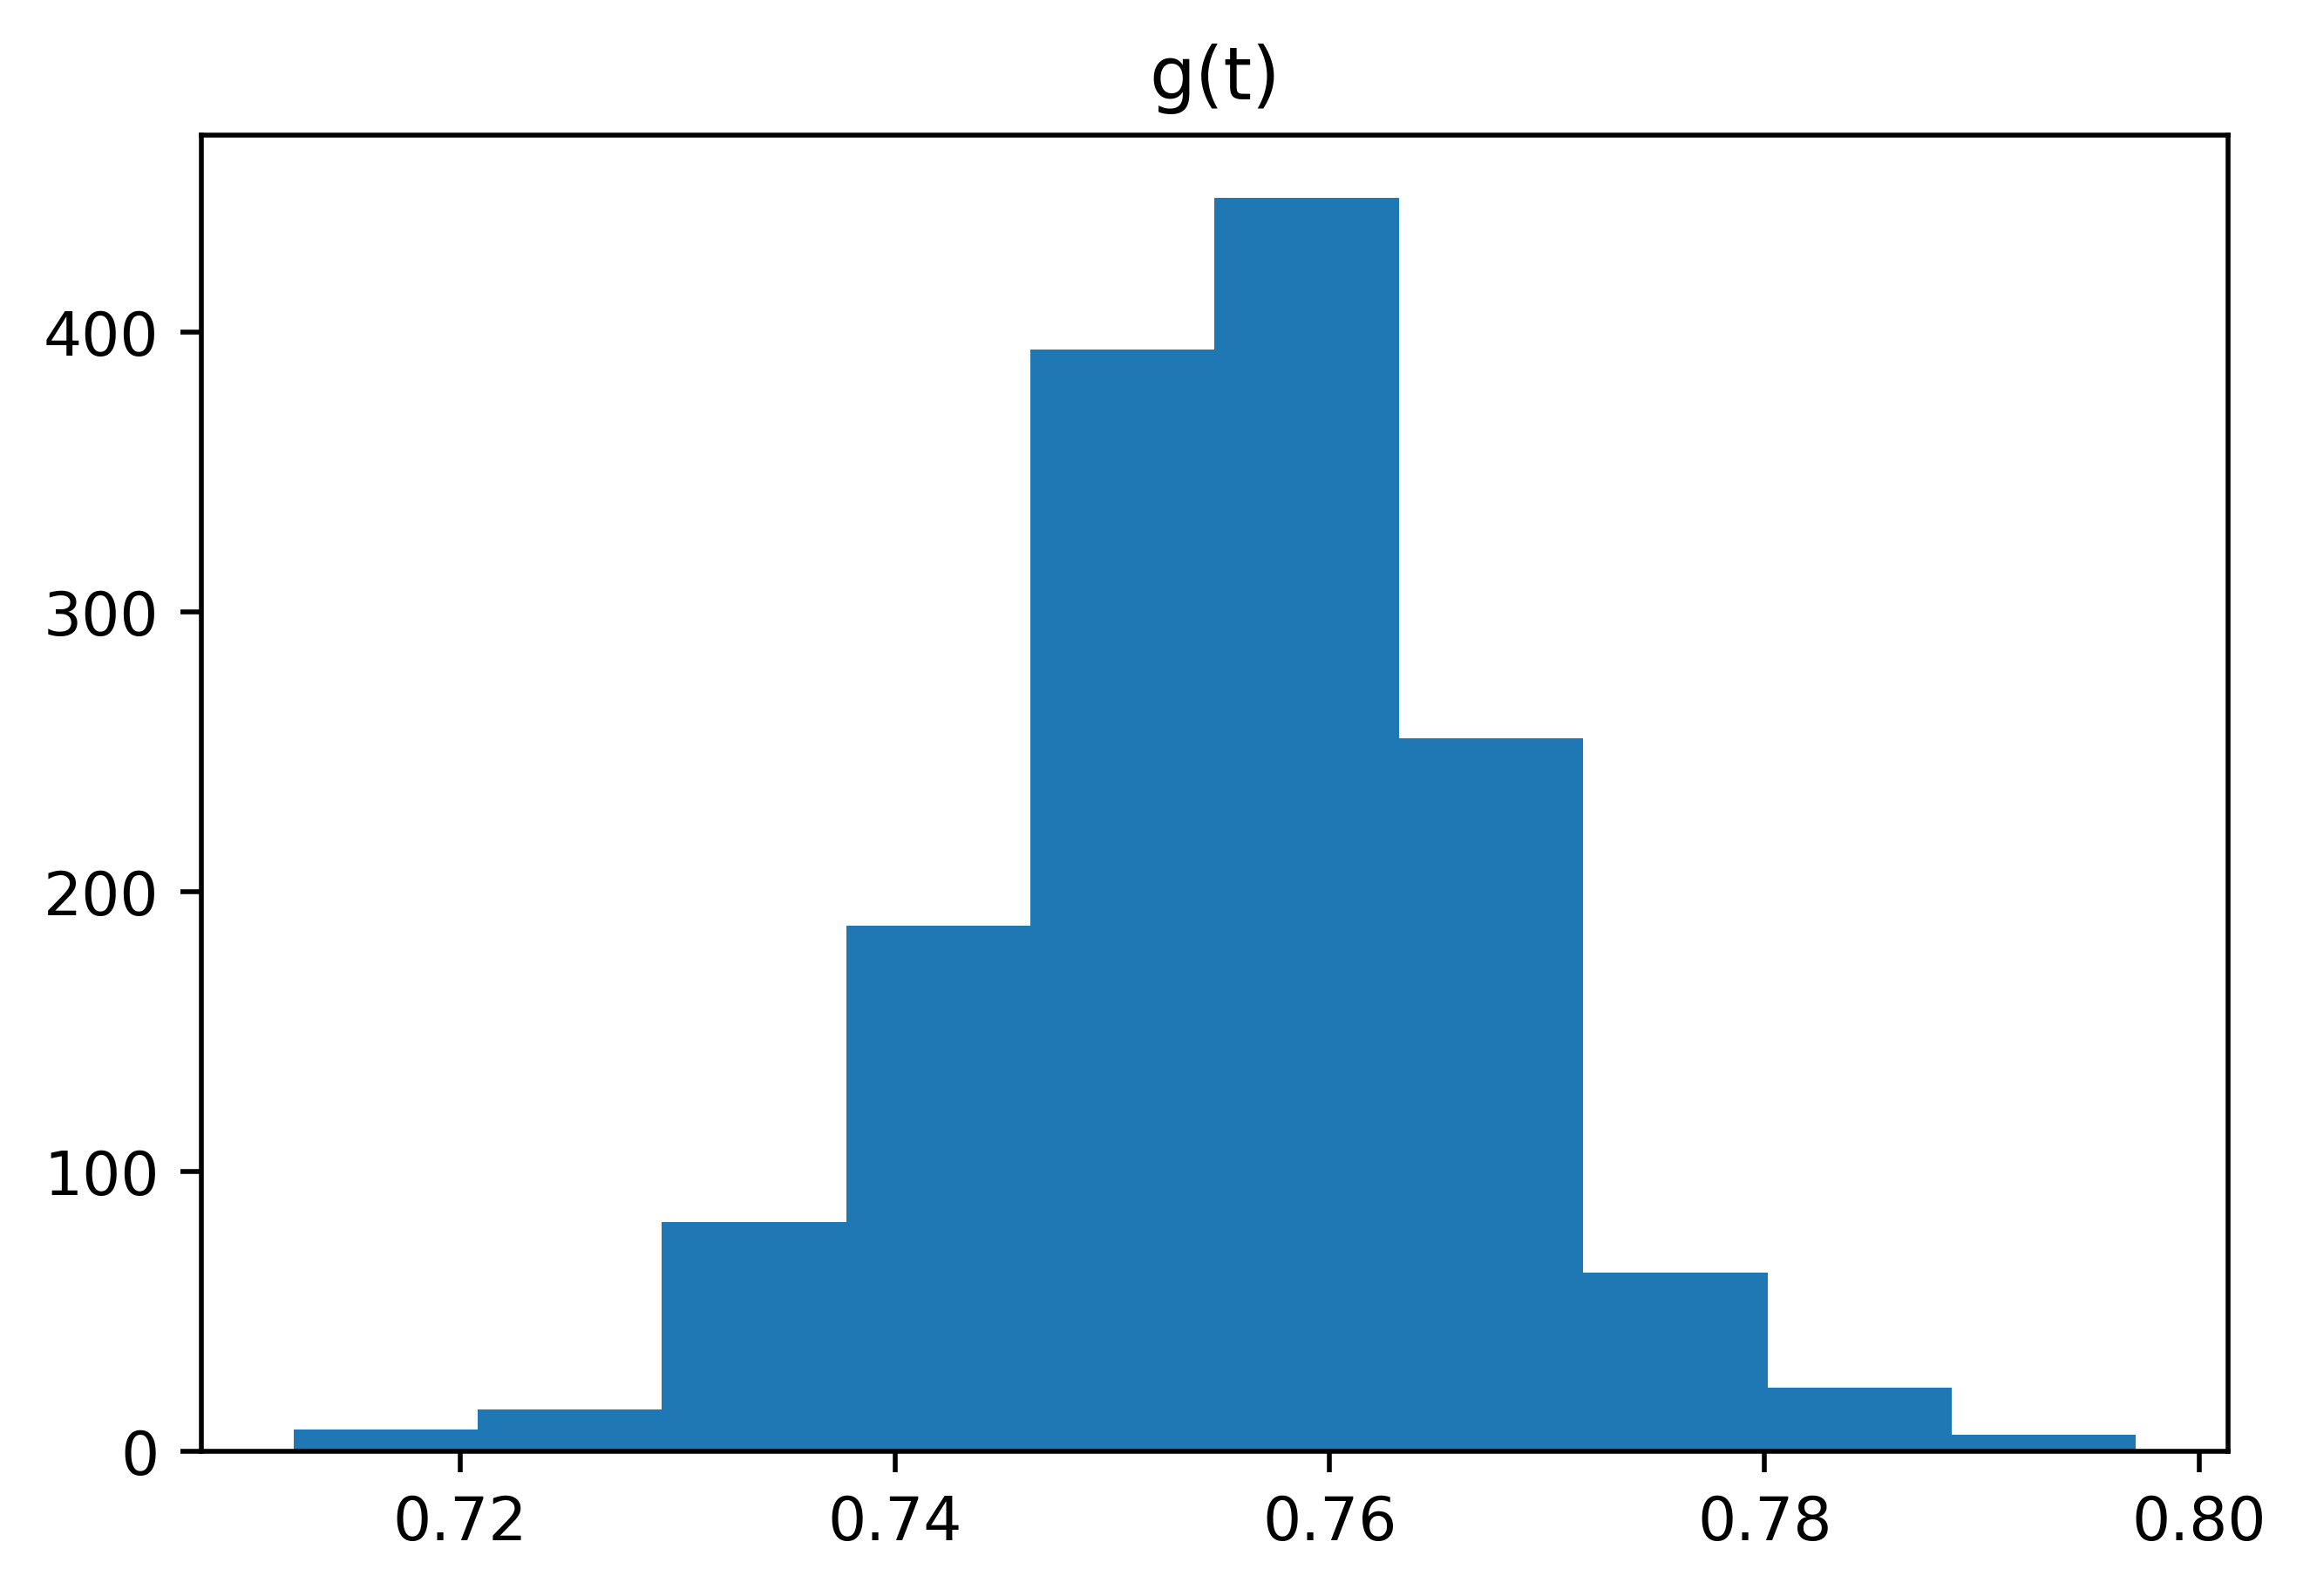

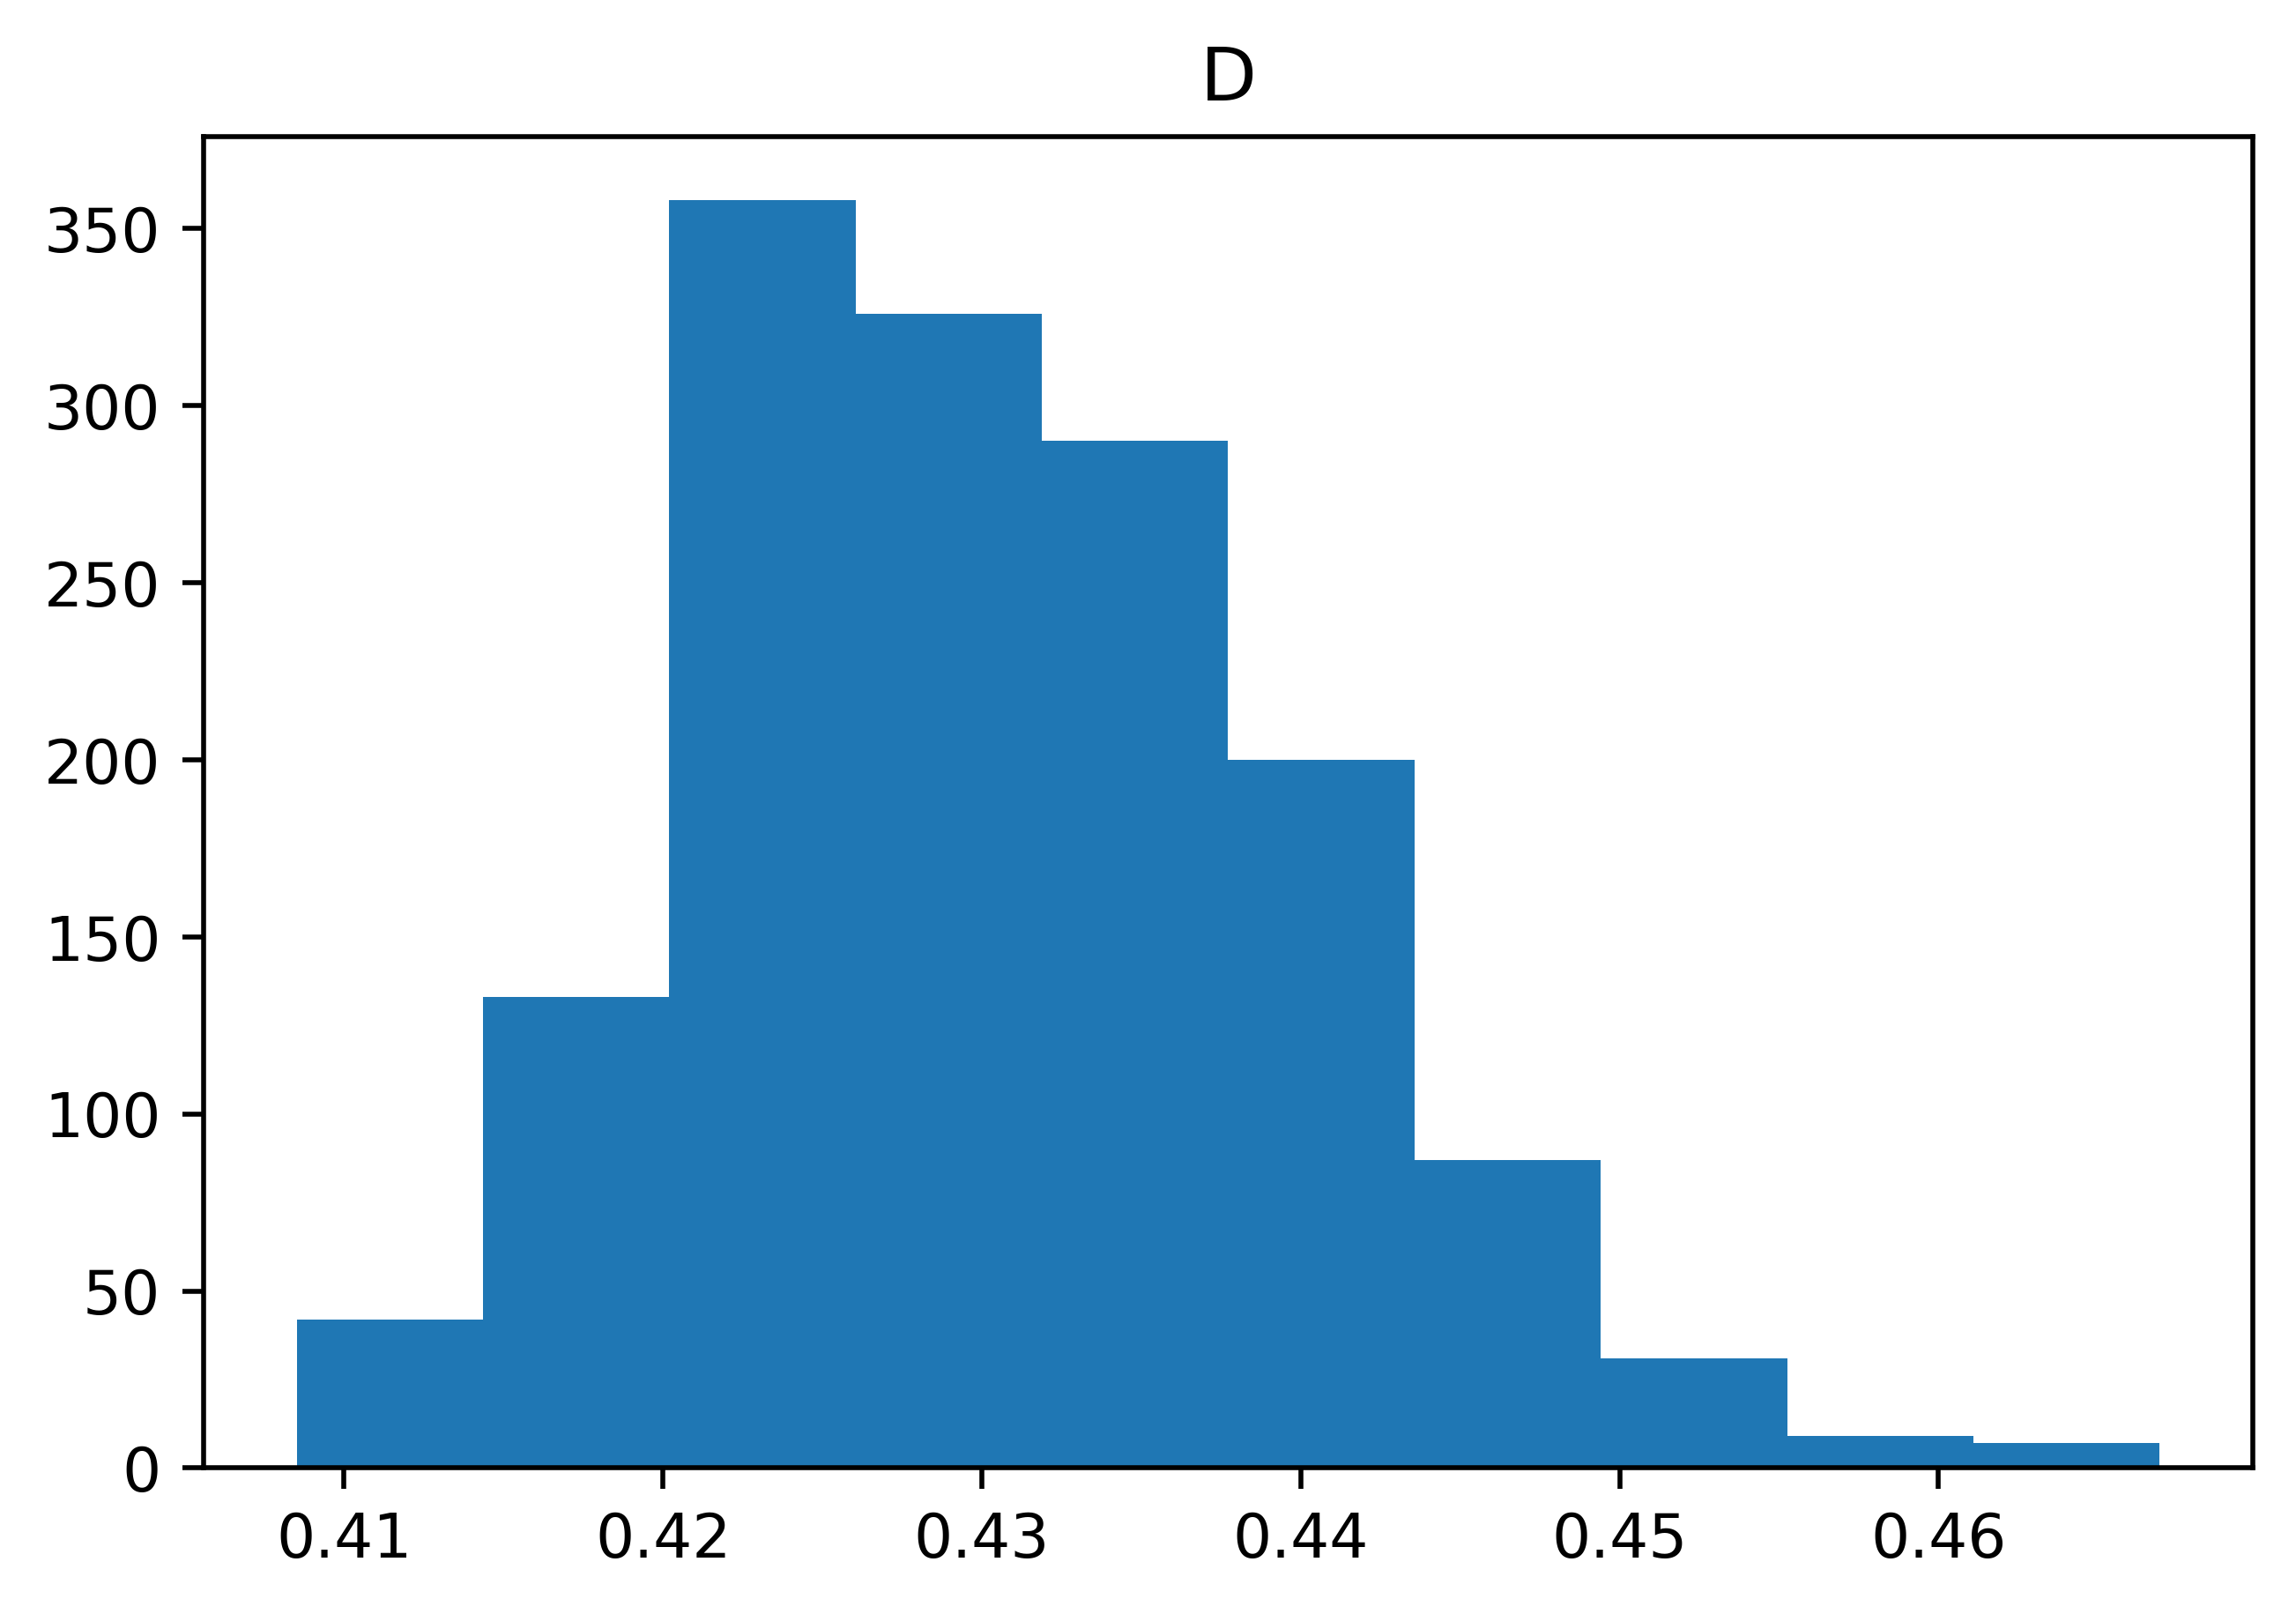

In [6]:
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
T = [0,0,1] #set initial tracer labeling

#create data structures to store output
errs = []
T_founds = []
fluxImageG = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageD = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
P_trues = []
P_preds = []

#get isotopologues with mean intensity > 1%
goodInd = []
for t in range(len(tensorFilt)):
    trel = tensorFilt[t][newImageBoundary > .5]
    if np.mean(trel) > 0.01:
        goodInd.append(t)

#do pixel by pixel ISA
for r in range(len(tensorFilt[0])):
    for c in range(len(tensorFilt[0][0])):
        #get product labeling
        P = tensorFilt[:,r,c]
        
        #if not on background pixel
        if np.sum(P) > .5:
            #fit ISA
            g,D,T_found,err,P_pred = ISAFit(T,N,P,func,goodInd)
            
            #save results in data structures
            errs.append(err)
            T_founds.append(T_found)
            P_trues.append(P)
            P_preds.append(P_pred)
        else:
            g,D = 0,0
        fluxImageG[r,c] = g
        fluxImageD[r,c] = D

#show and save images
plt.imshow(fluxImageG,cmap=colormap)
im = Image.fromarray(fluxImageG)
im.save(filename.replace(".txt","") + "_" + formula + "_g_" + '.tif')
plt.colorbar()
plt.title("g")
plt.figure()
plt.imshow(fluxImageD,cmap=colormap)
im = Image.fromarray(fluxImageD)
im.save(filename.replace(".txt","") + "_" + formula + "_D_" + '.tif')
plt.title("D")
plt.colorbar()

#plot histogram of sum of squared errors
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("numPixels")

#output found tracer labeling
plt.figure()
T_founds = np.array([t/np.sum(t) for t in T_founds])
T_found = np.mean(T_founds,axis=0)
print("T (mean) = ",T_found)
for t in range(len(T_found)):
    plt.hist(T_founds[:,t],label="M+"+str(t))
plt.legend()

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.mean(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.mean(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)

plt.figure()

plt.hist(fluxImageG[fluxImageG > 0].flatten())
plt.title("g(t)")
plt.figure()
plt.hist(fluxImageD[fluxImageD > 0].flatten())
plt.title("D")
